In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from datetime import datetime
from pathlib import Path

BASE_DIR = Path(os.path.abspath(''))
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

Working directory: c:\Users\jespe\Documents\GitHub_local\ARFusion


## Functions

### Processing and formatting CV results 

In [2]:
def get_average_and_std_df(results_dict, with_metric_as_index=False):
    losses = results_dict['losses']
    accs = results_dict['accs']
    iso_accs = results_dict['iso_accs']
    sensitivities = results_dict['sensitivities']
    specificities = results_dict['specificities']
    f1_scores = results_dict['F1_scores']
    
    losses_avg = np.mean(losses)
    losses_std = np.std(losses)
    accs_avg = np.mean(accs)
    accs_std = np.std(accs)
    iso_accs_avg = np.mean(iso_accs)
    iso_accs_std = np.std(iso_accs)
    sens_avg = np.mean(sensitivities)
    sens_std = np.std(sensitivities)
    spec_avg = np.mean(specificities)
    spec_std = np.std(specificities)
    f1_avg = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    df_CV = pd.DataFrame(data={
        "metric": ["Loss", 'Accuracy', 'Isolate accuracy', 'Sensitivity', 'Specificity', 'F1'], 
        "avg": [losses_avg, accs_avg, iso_accs_avg, sens_avg, spec_avg, f1_avg], 
        "std": [losses_std, accs_std, iso_accs_std, sens_std, spec_std, f1_std]
    })
    if with_metric_as_index:
        df_CV.set_index("metric", inplace=True)
    return df_CV


def get_ab_stats_df(results_dict, with_ab_as_index=False):
    ab_stats_list = results_dict['ab_stats']
    
    data_dict = {}
    antibiotics = ab_stats_list[0]['antibiotic'].tolist()
    data_dict.update({"antibiotic": antibiotics})
    for ab_stats in ab_stats_list:
        ab_stats['S_share'] = ab_stats['num_S'] / ab_stats['num_tot']
        ab_stats['R_share'] = ab_stats['num_R'] / ab_stats['num_tot']

    num_tot = np.array([ab_stats['num_tot'].tolist() for ab_stats in ab_stats_list])
    avg_num = np.mean(num_tot, axis=0).astype(int).tolist()
    std_num = np.std(num_tot, axis=0).tolist()
    s_shares = np.array([ab_stats['S_share'].tolist() for ab_stats in ab_stats_list])
    r_shares = np.array([ab_stats['R_share'].tolist() for ab_stats in ab_stats_list])
    s_share_median = np.median(s_shares, axis=0).tolist()
    s_share_std = np.std(s_shares, axis=0).tolist()
    r_share_median = np.median(r_shares, axis=0).tolist()
    r_share_std = np.std(r_shares, axis=0).tolist()
    data_dict.update({
        "avg_num": avg_num, "std_num":std_num,
        "S_share_median": s_share_median, "R_share_median": r_share_median,
        "S_share_std":s_share_std, "R_share_std": r_share_std
    })
    
    metrics = ['accuracy', 'sensitivity', 'specificity', "precision", 'F1']
    for metric in metrics:
        arr = np.array([ab_stats[metric] for ab_stats in ab_stats_list])
        avg = np.nanmean(arr, axis=0)
        std = np.nanstd(arr, axis=0)
        data_dict.update({metric+"_avg": avg.tolist(), metric+"_std": std.tolist()})

    df_ab_CV = pd.DataFrame(data=data_dict)
    if with_ab_as_index:
        df_ab_CV.set_index("antibiotic", inplace=True)
    return df_ab_CV

### TEMPORARY FIX - make sure no GPU tensors are saved in the results
import pickle, io
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


### Plotting functions

In [3]:
def plot_metric_by_ab(
    df_CV_ab,
    metric,
    use_std = True,
    sort_by_desc_metric = True,
    legend_labels = None,
    legend_loc = None,
    colors = ['slategray', 'tab:green', 'gold', 'tab:red'],
    title = None, 
    figsize = (12, 8), 
    save_path = None
):
    _, ax = plt.subplots(figsize=figsize)
    if sort_by_desc_metric:
        df_CV_ab = df_CV_ab.sort_values(by=(metric+'_avg', 'No PT'), ascending=False)
    if use_std:
        df_CV_ab.plot(kind='bar', y=metric+'_avg', yerr=metric+'_std', rot=0, figsize=(13, 8), capsize=2, ecolor='k', color=colors, ax=ax)
    else:
        df_CV_ab.plot(kind='bar', y=metric+'_avg', rot=0, figsize=(13, 8), color=colors, ax=ax)
    if title:
        if title == 'none':
            pass
        else:
            ax.set_title(title) 
    else:
        ax.set_title(f'{metric} by antibiotic')
    ax.set_xlabel('Antibiotic')
    ax.set_ylabel(metric)
    model_names = df_CV_ab[metric+'_avg'].columns.tolist()
    ax.legend(legend_labels if legend_labels else model_names, loc=legend_loc)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


def plot_metric_by_ab_with_distr(
    df_CV_ab,
    metric,
    use_std = True,
    sort_by_desc_S_share = True,
    show_distr_std = False,
    legend_labels = None,
    legend_loc = None,
    colors = ['slategray', 'tab:green', 'gold', 'tab:red'],
    title = None, 
    figsize = (12, 8), 
    save_path = None
):
    model_names = df_CV_ab[metric+'_avg'].columns.tolist()
    _, ax = plt.subplots(figsize=(13, 8))
    if sort_by_desc_S_share:
        df_CV_ab = df_CV_ab.sort_values(by='S_share_median', ascending=False)
    ind = np.arange(len(df_CV_ab.index))
    width = 0.15
    if use_std:
        for i, model in enumerate(model_names):
            ax.bar(
                ind + (i-1)*width, df_CV_ab[metric+'_avg'][model], width, yerr=df_CV_ab[metric+'_std'][model], 
                label=model, color=colors[i], capsize=2, ecolor='k'
            )
    else:
        for i, model in enumerate(model_names):
            ax.bar(ind + (i-1)*width, df_CV_ab[metric+'_avg'][model], width, label=model, color=colors[i])
    if show_distr_std:
        ax.bar(ind + 3*width, df_CV_ab['S_share_median'], width, color='darkgreen', label='S share', yerr=df_CV_ab['S_share_std'], capsize=2, ecolor='k')
        ax.bar(ind + 3*width, df_CV_ab['R_share_median'], width, bottom=df_CV_ab['S_share_median'], color='darkred', label='R share', yerr=df_CV_ab['R_share_std'], capsize=2, ecolor='k')
    else:
        ax.bar(ind + 3*width, df_CV_ab['R_share_median'], width, bottom=df_CV_ab['S_share_median'], color='darkred', label='R share')
        ax.bar(ind + 3*width, df_CV_ab['S_share_median'], width, color='darkgreen', label='S share')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(df_CV_ab.index)
    if title:
        if title == 'none':
            pass
        else:
            ax.set_title(title) 
    else:
        ax.set_title(f'{metric} by antibiotic')
    ax.set_xlabel('Antibiotic')
    ax.set_ylabel(metric)
    ax.legend(legend_labels if legend_labels else model_names, loc=legend_loc)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

## Compare effect of masking method on antibiotic distributions

In [4]:
results_random = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_0.9', 'CV_results.pkl'))
results_class = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_class', 'CV_results.pkl'))

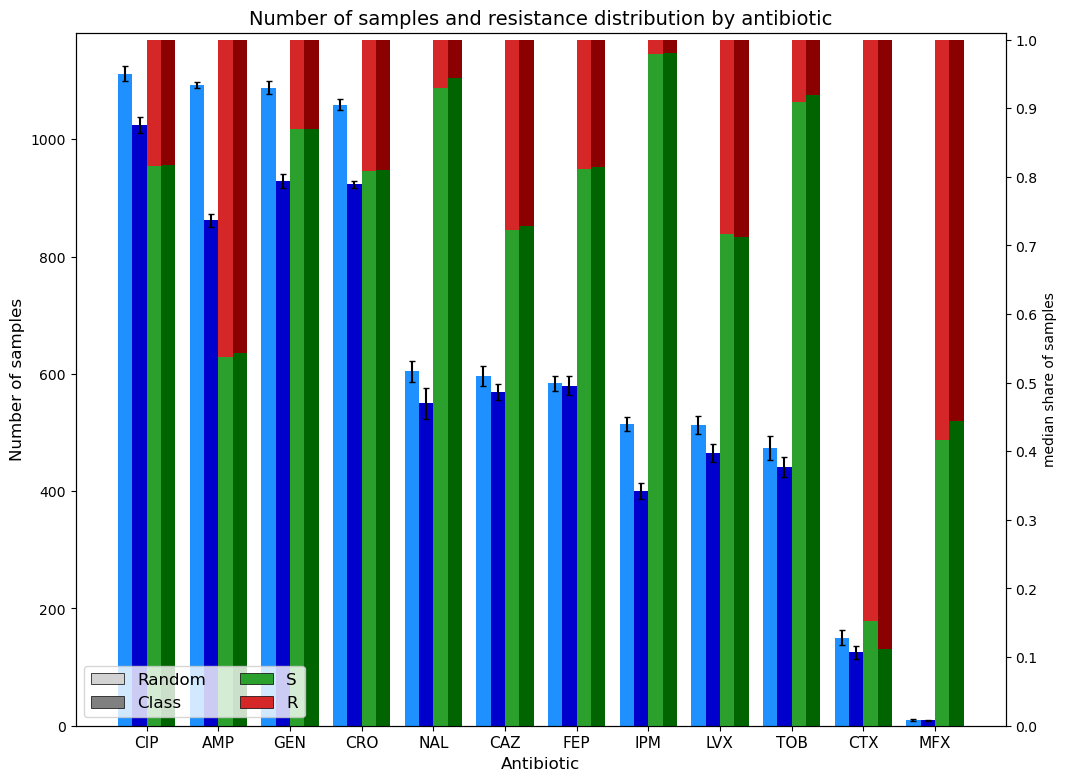

In [5]:
results_random = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_0.9', 'CV_results.pkl'))
results_class = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_class', 'CV_results.pkl'))
df_ab_random = get_ab_stats_df(results_random, with_ab_as_index=True)
df_ab_class = get_ab_stats_df(results_class, with_ab_as_index=True)

fig, ax = plt.subplots(figsize=(12, 9))
bar_width = 0.2
df_ab_random = df_ab_random.sort_values(by='avg_num', ascending=False)
df_ab_class = df_ab_class.reindex_like(df_ab_random)
ind = np.arange(len(df_ab_random.index))
bar_num = ax.bar(
    ind-3/2*bar_width, df_ab_random['avg_num'], width=bar_width, color='dodgerblue',
    yerr=df_ab_random['std_num'], capsize=2, ecolor='k'
)
bar_num_class = ax.bar(
    ind-bar_width/2, df_ab_class['avg_num'], width=bar_width, color='mediumblue',
    yerr=df_ab_class['std_num'], capsize=2, ecolor='k'
)
ax2 = ax.twinx()
bar_R_share = ax2.bar(
    ind+bar_width/2, df_ab_random['R_share_median'], bottom=df_ab_random['S_share_median'], width=bar_width, color='tab:red'
)
bar_S_share = ax2.bar(
    ind+bar_width/2, df_ab_random['S_share_median'], width=bar_width, color='tab:green'
)
bar_R_share_class = ax2.bar(
    ind+3/2*bar_width, df_ab_class['R_share_median'], bottom=df_ab_class['S_share_median'], width=bar_width, color='darkred'
)
bar_S_share_class = ax2.bar(
    ind+3/2*bar_width, df_ab_class['S_share_median'], width=bar_width, color='darkgreen'
)
ax.set_xticks(ind, df_ab_random.index, fontsize=11)
ax.set_title('Number of samples and resistance distribution by antibiotic', fontsize=14)
ax.set_xlabel('Antibiotic', fontsize=12)
ax.set_ylabel('Number of samples', fontsize=12)
ax2.set_ylabel('median share of samples')
ax2.set_ylim(0, 1.01)
ax2.set_yticks(np.arange(0, 1.01, 0.1))

# custom legend
from matplotlib.patches import Rectangle

num_rand = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
num_class = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
S_share = Rectangle((0,0),1,1,fc='tab:green', edgecolor='k', linewidth=0.5)
R_share = Rectangle((0,0),1,1,fc='tab:red', edgecolor='k', linewidth=0.5)

ax2.legend(
    handles=[num_rand, num_class, S_share, R_share], 
    labels=['Random', 'Class', 'S', 'R'],
    loc='lower left',
    fontsize=12, 
    ncols=2
)
plt.show()

# Compare effect of pre-training difficulty and masking method

## PT: Random masking | FT: Random masking

In [6]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.75_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.75_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.75_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_0.9', 'CV_results.pkl'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.75_0.9', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.75_0.9', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.75_0.9', 'CV_results.pkl'))
model_names = ['No PT', 'Easy PT', 'Medium PT', 'Hard PT']
colors = ['slategray', 'tab:green', 'gold', 'tab:red']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

### Compare metrics

In [7]:
drop_metrics = ['Loss', 'Accuracy']

In [8]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                     std            \
model                No PT   Easy PT Medium PT   Hard PT     No PT   Easy PT   
metric                                                                         
Accuracy          0.928232  0.928151  0.929818  0.930254  0.003776  0.001626   
F1                0.825424  0.824272  0.828929  0.829979  0.009663  0.007573   
Isolate accuracy  0.697413  0.698188  0.706868  0.707643  0.025780  0.015917   
Loss              0.179347  0.180768  0.180203  0.179886  0.008396  0.006496   
Sensitivity       0.771163  0.766288  0.773357  0.774261  0.017981  0.016243   
Specificity       0.972445  0.973709  0.973883  0.974194  0.004926  0.003412   

                                      
model            Medium PT   Hard PT  
metric                                
Accuracy          0.002194  0.002049  
F1                0.008453  0.008462  
Isolate accuracy  0.018506  0.018192  
Loss              0.007619  0.007118  
Sensitivity       0.020368  0.016595  
Specificity       0.004413  0.002406

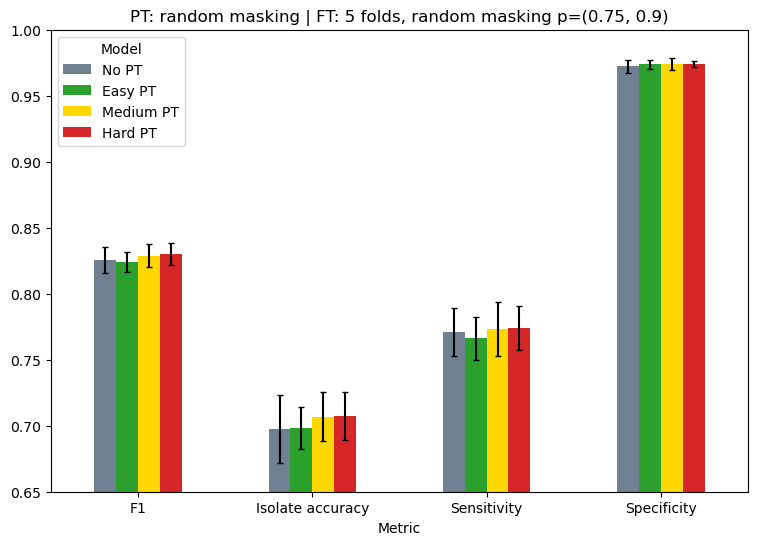

In [9]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model')
plt.ylim(0.65, 1)
plt.xlabel('Metric')
plt.title('PT: random masking | FT: 5 folds, random masking p=(0.75, 0.9)')
plt.show()

### Antibiotic level

In [10]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp
df_CV_ab

avg_num    std_num S_share_median R_share_median S_share_std  \
model                                                                     
antibiotic                                                                
AMP         1092.0   5.268776       0.537684       0.462316    0.006292   
CAZ          597.0  17.083325       0.722222       0.277778    0.009038   
CIP         1112.0  13.317657       0.816143       0.183857    0.009205   
CRO         1059.0   9.195651       0.808590       0.191410    0.008264   
CTX          150.0  12.467558       0.152318       0.847682    0.016547   
FEP          584.0  12.905813       0.811644       0.188356    0.007449   
GEN         1088.0  10.552725       0.870236       0.129764    0.007442   
IPM          514.0  11.872658       0.978474       0.021526    0.005756   
LVX          513.0  15.679286       0.716390       0.283610    0.029585   
MFX           10.0   1.854724       0.416667       0.583333    0.229326   
NAL          604.0  18.659046       0.929825       0.070175    0.009476   
TOB          473.0  20.635891       0.909639       0.090361    0.010737   

           R_share_std accuracy_avg                                ...  \
model                         No PT   Easy PT Medium PT   Hard PT  ...   
antibiotic                                                         ...   
AMP           0.006292     0.845983  0.848930  0.854607  0.852773  ...   
CAZ           0.009038     0.909904  0.912877  0.911046  0.911283  ...   
CIP           0.009205     0.942134  0.944093  0.942640  0.944591  ...   
CRO           0.008264     0.955449  0.953007  0.955252  0.956581  ...   
CTX           0.016547     0.923976  0.924936  0.931870  0.935539  ...   
FEP           0.007449     0.923059  0.916889  0.924356  0.924016  ...   
GEN           0.007442     0.924756  0.922941  0.924199  0.922382  ...   
IPM           0.005756     0.982955  0.982914  0.982156  0.982569  ...   
LVX           0.029585     0.929973  0.929849  0.932129  0.933821  ...   
MFX           0.229326     0.899444  0.864060  0.804060  0.879444  ...   
NAL           0.009476     0.960730  0.962399  0.963726  0.964245  ...   
TOB           0.010737     0.961341  0.960420  0.959141  0.961720  ...   

           precision_std              F1_avg                                \
model          Medium PT   Hard PT     No PT   Easy PT Medium PT   Hard PT   
antibiotic                                                                   
AMP             0.012224  0.021750  0.819967  0.821912  0.827511  0.826415   
CAZ             0.010440  0.012650  0.835374  0.840006  0.838016  0.839216   
CIP             0.018685  0.018229  0.836541  0.841027  0.836875  0.840777   
CRO             0.017240  0.017982  0.876125  0.870412  0.876369  0.881268   
CTX             0.005521  0.017451  0.954949  0.954918  0.959218  0.961995   
FEP             0.039514  0.031259  0.792724  0.775075  0.796163  0.793188   
GEN             0.056094  0.056651  0.643587  0.629473  0.649065  0.631611   
IPM             0.181147  0.142361  0.514213  0.463705  0.428687  0.493980   
LVX             0.021849  0.013345  0.876630  0.876426  0.881016  0.882832   
MFX             0.170873  0.110911  0.912442  0.885140  0.835059  0.894664   
NAL             0.070925  0.056581  0.642225  0.663224  0.671454  0.663953   
TOB             0.040535  0.061593  0.759546  0.744233  0.746615  0.764132   

              F1_std                                
model          No PT   Easy PT Medium PT   Hard PT  
antibiotic                                          
AMP         0.016556  0.011272  0.014626  0.015769  
CAZ         0.016270  0.012408  0.018339  0.008061  
CIP         0.004427  0.010528  0.010608  0.015879  
CRO         0.013051  0.016130  0.013929  0.009621  
CTX         0.007500  0.010158  0.006177  0.010077  
FEP         0.019509  0.020972  0.023329  0.015280  
GEN         0.060848  0.058203  0.057112  0.055006  
IPM         0.215181  0.086952  0.074165  0.071234  
LVX         0.015615

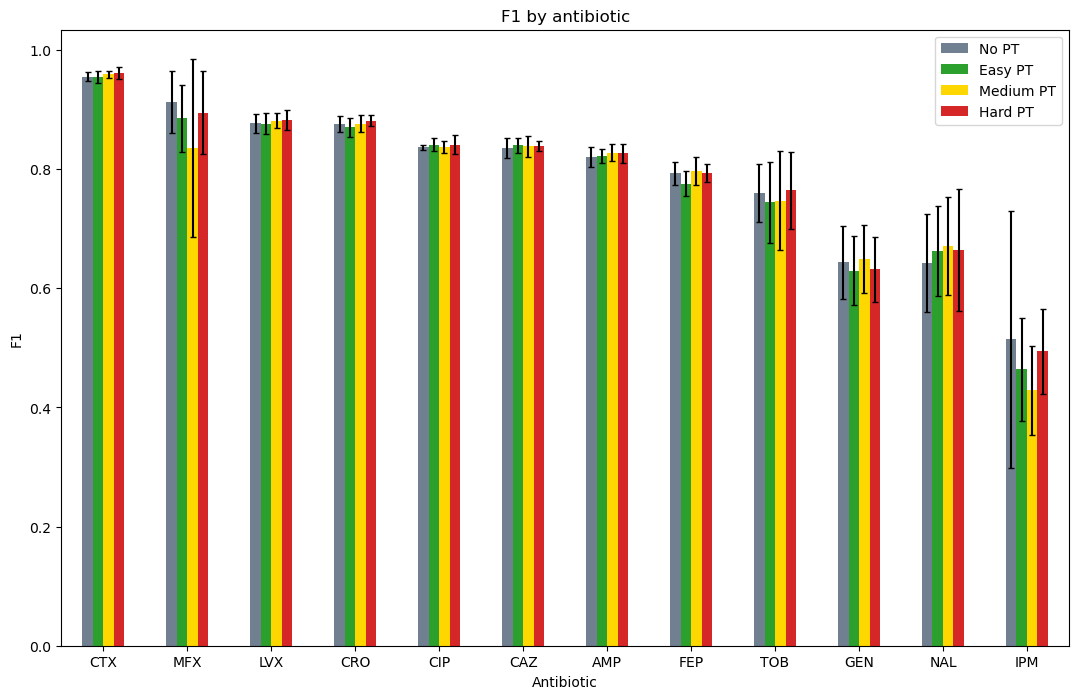

In [11]:
plot_metric_by_ab(df_CV_ab, 'F1')

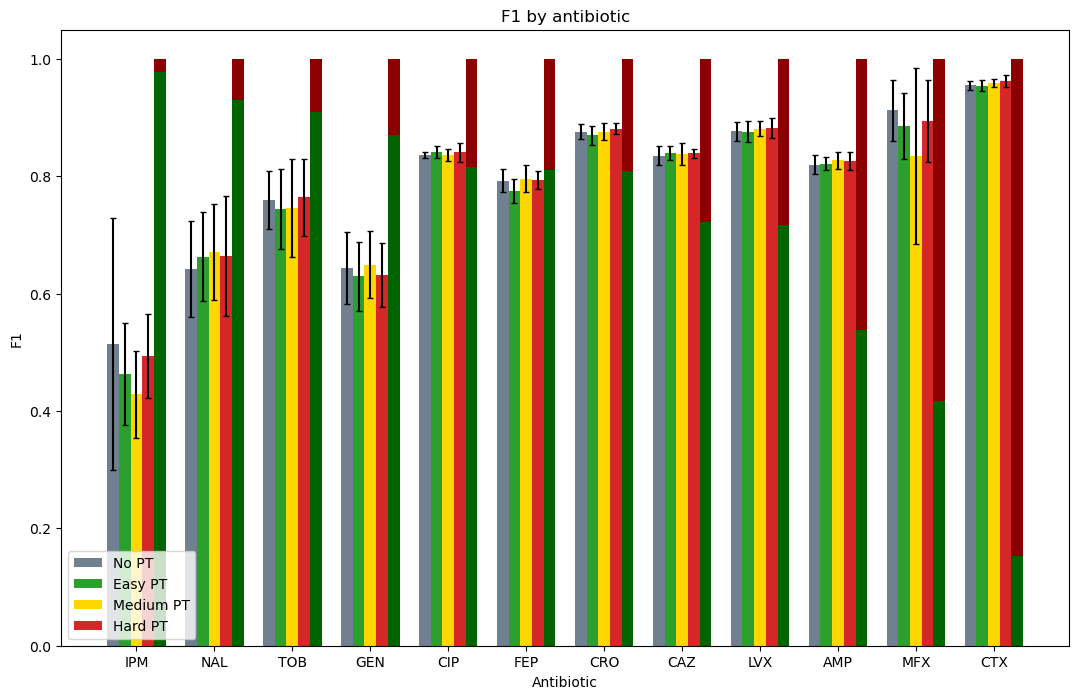

In [12]:
plot_metric_by_ab_with_distr(df_CV_ab, 'F1', show_distr_std=False, legend_loc='lower left')

## PT: Random masking | FT: Class masking

In [13]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.75_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.75_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.75_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_class', 'CV_results.pkl'))
# results_dict_noPT = torch.load(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_class', 'CV_results.pkl'), map_location=torch.device('cpu'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.75_class', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.75_class', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.75_class', 'CV_results.pkl'))
model_names = ['No PT', 'Easy PT', 'Medium PT', 'Hard PT']
colors = ['slategray', 'tab:green', 'gold', 'tab:red']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

### Compare metrics

In [14]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                     std            \
model                No PT   Easy PT Medium PT   Hard PT     No PT   Easy PT   
metric                                                                         
Accuracy          0.926392  0.928196  0.928102  0.928571  0.005512  0.003962   
F1                0.815009  0.820731  0.819692  0.820196  0.016198  0.012780   
Isolate accuracy  0.720647  0.728467  0.731078  0.732373  0.021687  0.016333   
Loss              0.190033  0.185553  0.183064  0.185488  0.015806  0.011738   
Sensitivity       0.756277  0.766741  0.762127  0.759956  0.017441  0.020946   
Specificity       0.972781  0.972159  0.973358  0.974558  0.004783  0.004897   

                                      
model            Medium PT   Hard PT  
metric                                
Accuracy          0.003686  0.003777  
F1                0.011915  0.012596  
Isolate accuracy  0.014193  0.015532  
Loss              0.010023  0.009750  
Sensitivity       0.015952  0.018397  
Specificity       0.003606  0.002790

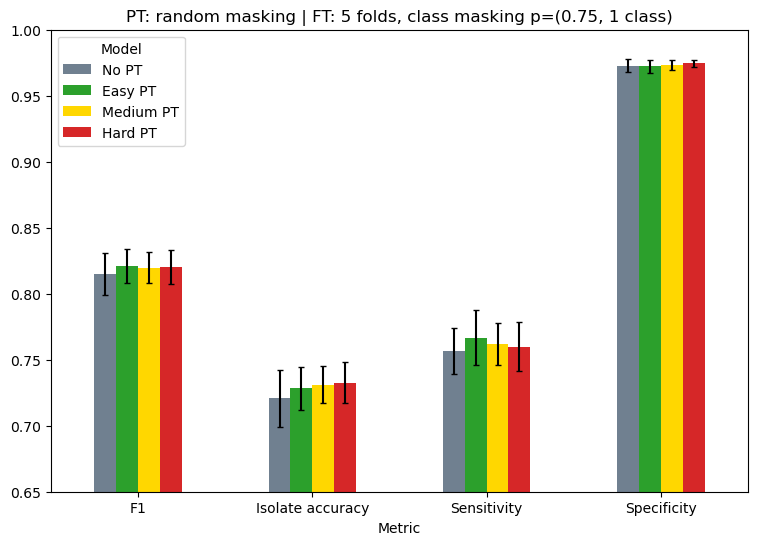

In [15]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model')
plt.ylim(0.65, 1)
plt.xlabel('Metric')
plt.title('PT: random masking | FT: 5 folds, class masking p=(0.75, 1 class)')
plt.show()

### Antibiotic level

In [16]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp

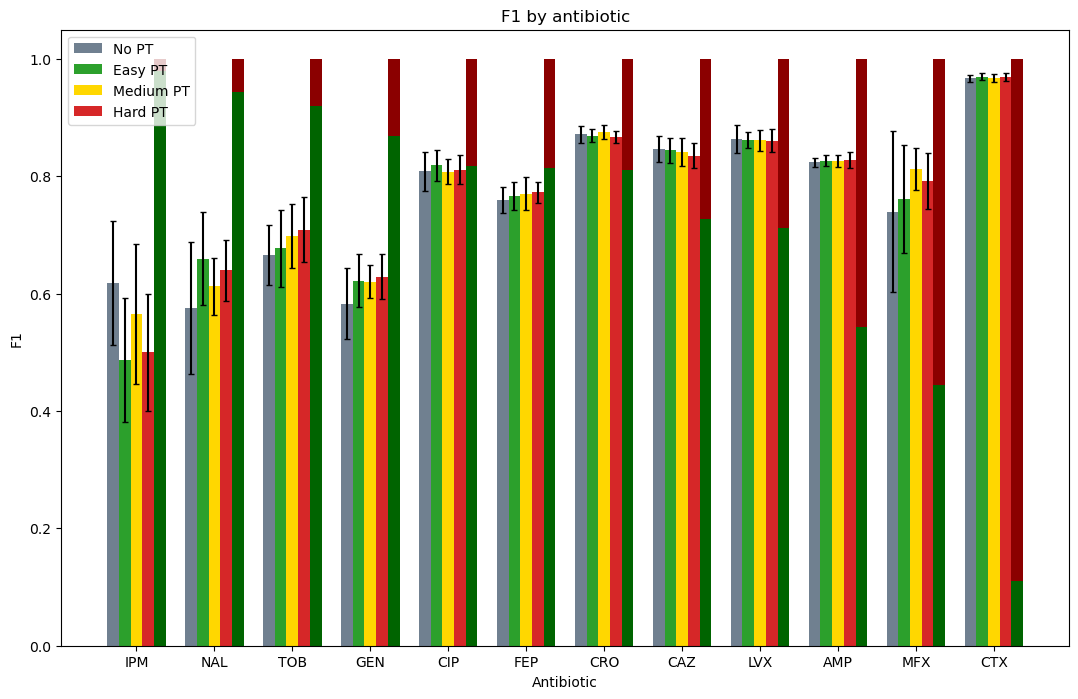

In [17]:
plot_metric_by_ab_with_distr(df_CV_ab, 'F1', show_distr_std=False)

## PT: Class masking | FT: Random masking

In [18]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp

### Compare metrics

In [19]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.75_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.75_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.75_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_0.9', 'CV_results.pkl'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.75_0.9', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.75_0.9', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.75_0.9', 'CV_results.pkl'))
model_names = ['No CPT', 'Easy CPT', 'Medium CPT', 'Hard CPT']
colors = ['slategray', 'darkgreen', 'darkgoldenrod', 'darkred']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

In [20]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                      std            \
model               No CPT  Easy CPT Medium CPT  Hard CPT    No CPT  Easy CPT   
metric                                                                          
Accuracy          0.928232  0.928419   0.928571  0.928524  0.003776  0.003243   
F1                0.825424  0.826952   0.825899  0.826801  0.009663  0.005724   
Isolate accuracy  0.697413  0.701289   0.704234  0.702218  0.025780  0.022614   
Loss              0.179347  0.180222   0.180526  0.182211  0.008396  0.005461   
Sensitivity       0.771163  0.776799   0.769804  0.775033  0.017981  0.011504   
Specificity       0.972445  0.971148   0.973327  0.971788  0.004926  0.003825   

                                       
model            Medium CPT  Hard CPT  
metric                                 
Accuracy           0.002287  0.003044  
F1                 0.005471  0.006411  
Isolate accuracy   0.020049  0.018932  
Loss               0.005875  0.006349  
Sensitivity        0.008458  0.011067  
Specificity        0.002417  0.003094

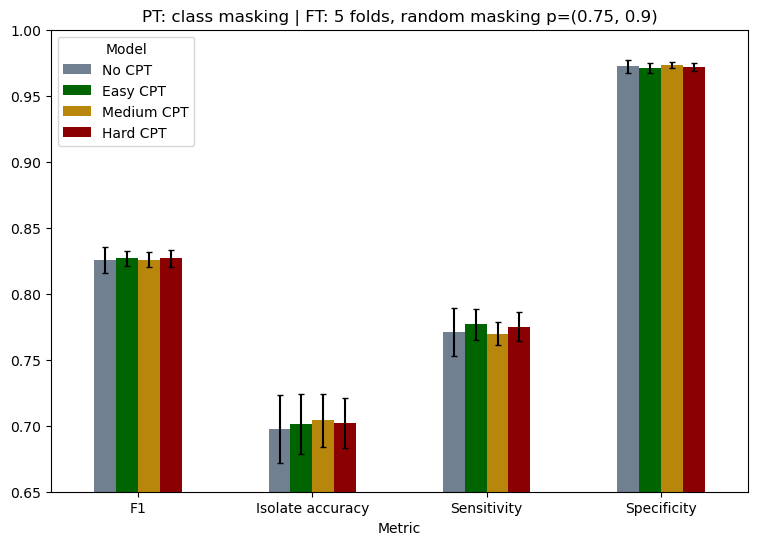

In [21]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model')
plt.ylim(0.65, 1)
plt.xlabel('Metric')
plt.title('PT: class masking | FT: 5 folds, random masking p=(0.75, 0.9)')
plt.show()

### Antibiotic level

In [22]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp

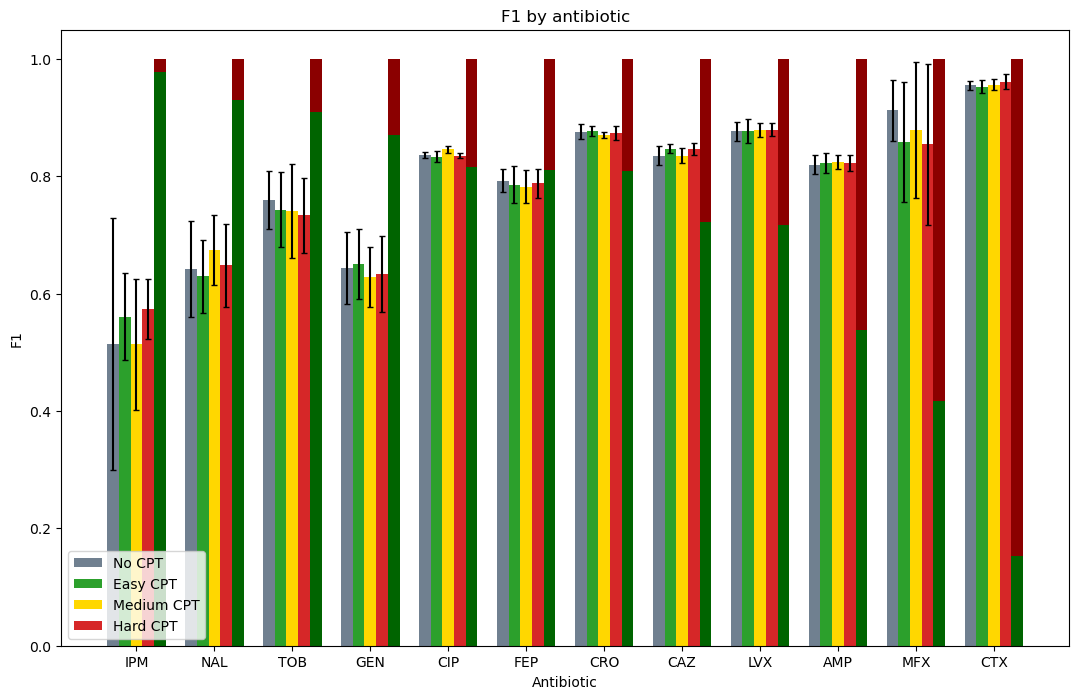

In [23]:
plot_metric_by_ab_with_distr(df_CV_ab, 'F1', show_distr_std=False, legend_loc='lower left')

## PT: Class masking | FT: Class masking

In [24]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.75_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.75_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.75_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_class', 'CV_results.pkl'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.75_class', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.75_class', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.75_class', 'CV_results.pkl'))
model_names = ['No PT', 'Easy CPT', 'Medium CPT', 'Hard CPT']
colors = ['slategray', 'darkgreen', 'darkgoldenrod', 'darkred']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

### Compare metrics

In [25]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                      std            \
model                No PT  Easy CPT Medium CPT  Hard CPT     No PT  Easy CPT   
metric                                                                          
Accuracy          0.926392  0.928223   0.929823  0.928366  0.005512  0.003741   
F1                0.815009  0.819828   0.823968  0.821083  0.016198  0.012238   
Isolate accuracy  0.720647  0.727814   0.732204  0.728141  0.021687  0.018225   
Loss              0.190033  0.186803   0.183251  0.186382  0.015806  0.010860   
Sensitivity       0.756277  0.761605   0.766214  0.767678  0.017441  0.015193   
Specificity       0.972781  0.973661   0.974394  0.972048  0.004783  0.002874   

                                       
model            Medium CPT  Hard CPT  
metric                                 
Accuracy           0.003293  0.003887  
F1                 0.011790  0.014972  
Isolate accuracy   0.014681  0.014878  
Loss               0.012181  0.010486  
Sensitivity        0.018371  0.026705  
Specificity        0.003547  0.004924

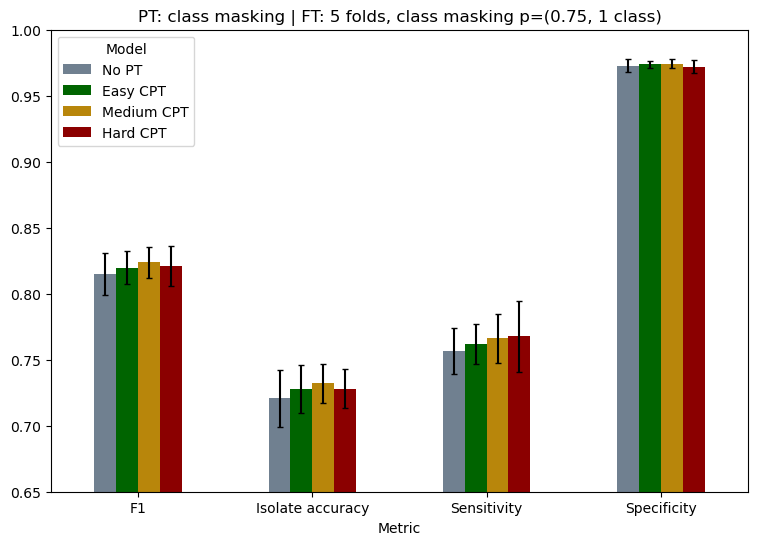

In [26]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model')
plt.ylim(0.65, 1)
plt.xlabel('Metric')
plt.title('PT: class masking | FT: 5 folds, class masking p=(0.75, 1 class)')
plt.show()

### Antibiotic level

In [27]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp

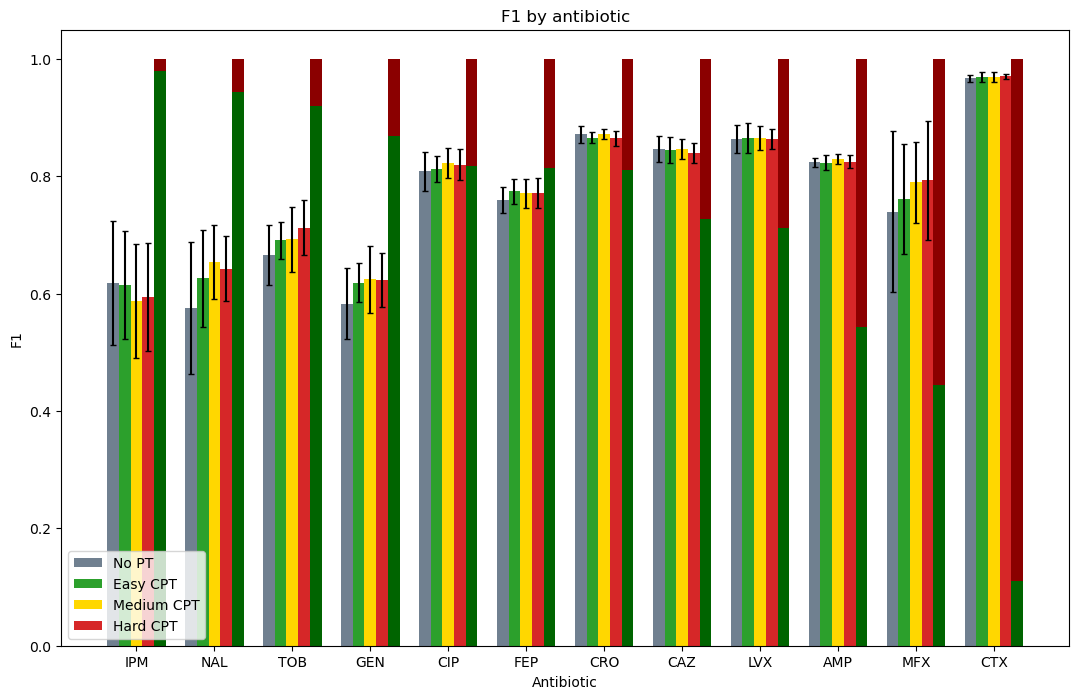

In [28]:
plot_metric_by_ab_with_distr(df_CV_ab, 'F1', show_distr_std=False, legend_loc='lower left')

# Compare pre-training masking strategies and difficulties

In [29]:
def load_and_create_abs_and_rel_diff_dfs(
    train_params: str,
    train_share: str = None,
    model_names = ['No PT', 'Easy PT', 'Easy CPT', 'Medium PT', 'Medium CPT', 'Hard PT', 'Hard CPT'], 
    colors = ['slategray', 'forestgreen', 'darkgreen', 'gold', 'darkgoldenrod', 'red', 'darkred'],
):
    results_dict_list = []
    if train_share:
        for model_name in model_names:
            model_name = model_name.replace(' ', '')
            results_dict_list.append(
                pd.read_pickle(
                    os.path.join(BASE_DIR, 'results', 'MM', f'FT_{model_name}_{train_params}_train_share{train_share}', 'CV_results.pkl')
                )
            )
    else:
        for model_name in model_names:
            model_name = model_name.replace(' ', '')
            results_dict_list.append(
                pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', f'FT_{model_name}_{train_params}', 'CV_results.pkl'))
            )
    df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
    df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
    df_CV = df_CV.reindex(columns=model_names, level=1)
    df_diff = df_CV.drop(('avg', 'No PT'), axis=1).drop(('std', 'No PT'), axis=1)
    for i in range(df_diff.shape[0]):
        df_diff.iloc[i, :].loc['avg'] = df_diff.iloc[i, :] - df_CV.loc[:, ('avg', 'No PT')].values[i]
        std_1 = df_diff.iloc[i, :].loc['std'].values**2/5
        std_2 = df_CV.loc[:, ('std', 'No PT')].values[i]**2/5
        df_diff.iloc[i, :].loc['std'] = np.sqrt(std_1 + std_2) # standard error of the difference of means
    return df_CV, df_diff
    

## p = (0.75, 0.9)

In [30]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.75_0.9')

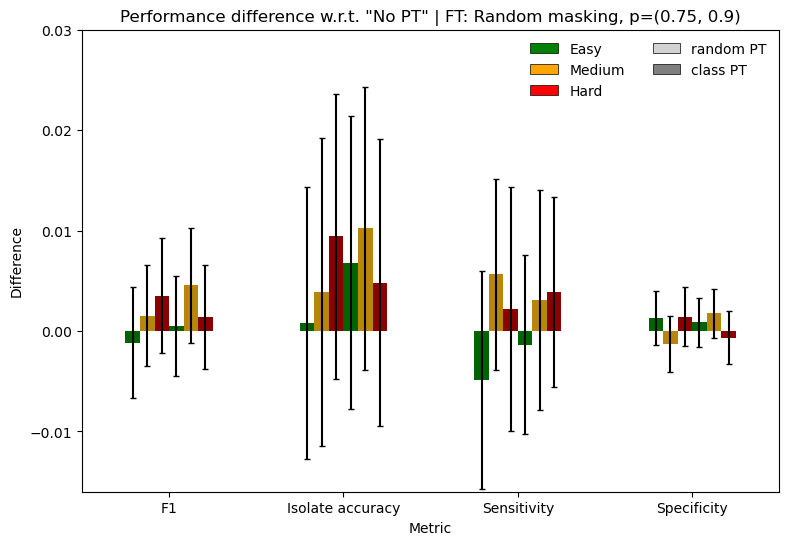

In [31]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('Performance difference w.r.t. "No PT" | FT: Random masking, p=(0.75, 0.9)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,  
    # loc='lower right',
)
plt.ylim(-0.016, 0.03)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rnd0.9FT_rel_diff_w_error.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

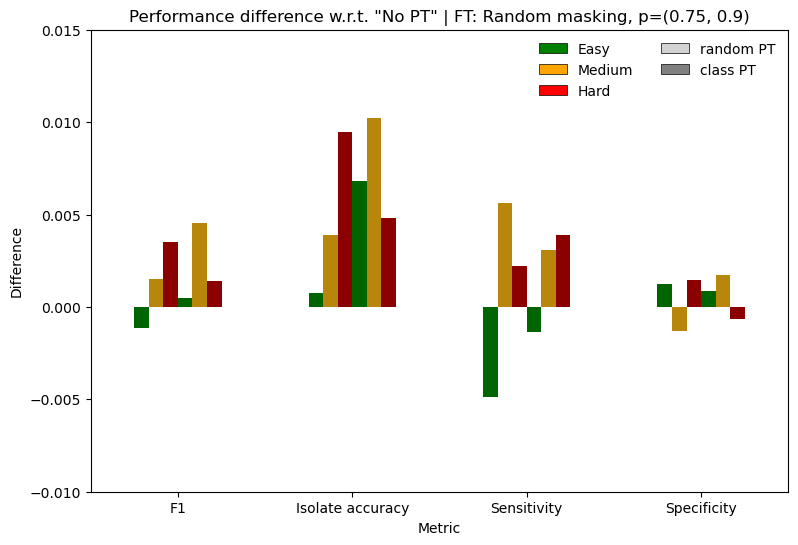

In [32]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', rot=0, figsize=(9, 6), color=colors[1:], ax=ax)
ax.set_title('Performance difference w.r.t. "No PT" | FT: Random masking, p=(0.75, 0.9)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,  
    # loc='lower right',
)
plt.ylim(-0.01, 0.015)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rnd0.9FT_rel_diff.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

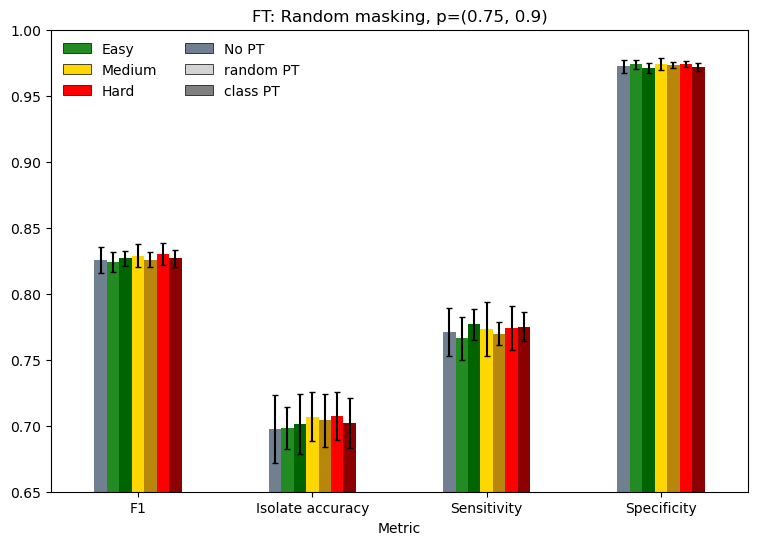

In [33]:
colors = ['slategray', 'forestgreen', 'darkgreen', 'gold', 'darkgoldenrod', 'red', 'darkred']
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.65, 1)
plt.xlabel('Metric')
plt.title('FT: Random masking, p=(0.75, 0.9)')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rnd0.9FT_abs_diff.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

## p = (0.75, 0.7)

In [34]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.75_0.7')

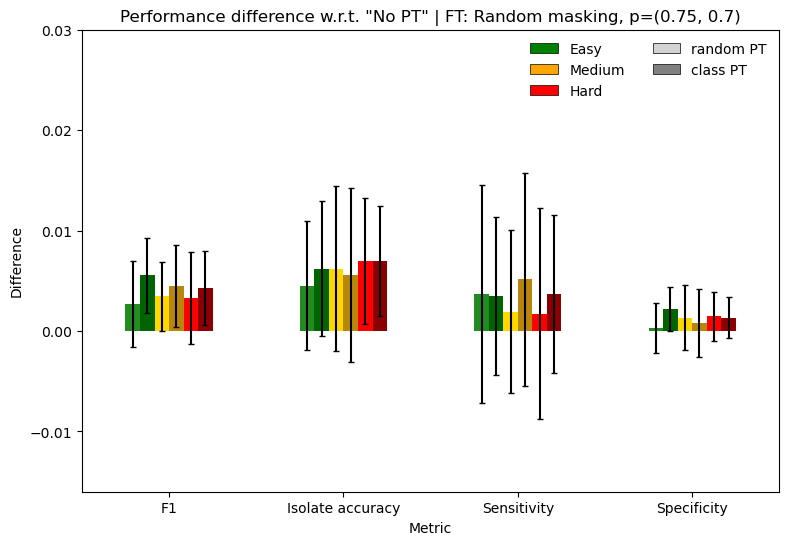

In [35]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('Performance difference w.r.t. "No PT" | FT: Random masking, p=(0.75, 0.7)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,  
    # loc='lower right',
)
plt.ylim(-0.016, 0.03)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rnd0.7FT_rel_diff_w_error.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

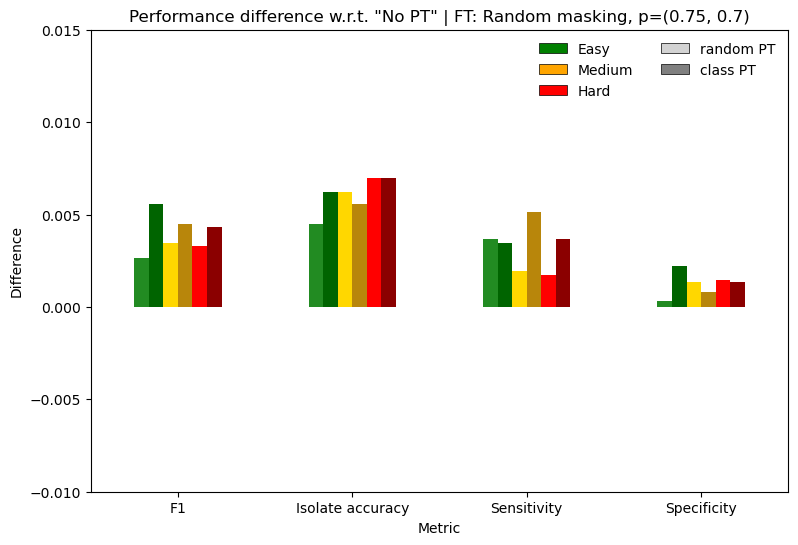

In [36]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', rot=0, figsize=(9, 6), color=colors[1:], ax=ax)
ax.set_title('Performance difference w.r.t. "No PT" | FT: Random masking, p=(0.75, 0.7)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,  
    # loc='lower right',
)
plt.ylim(-0.01, 0.015)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rnd0.7FT_rel_diff.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

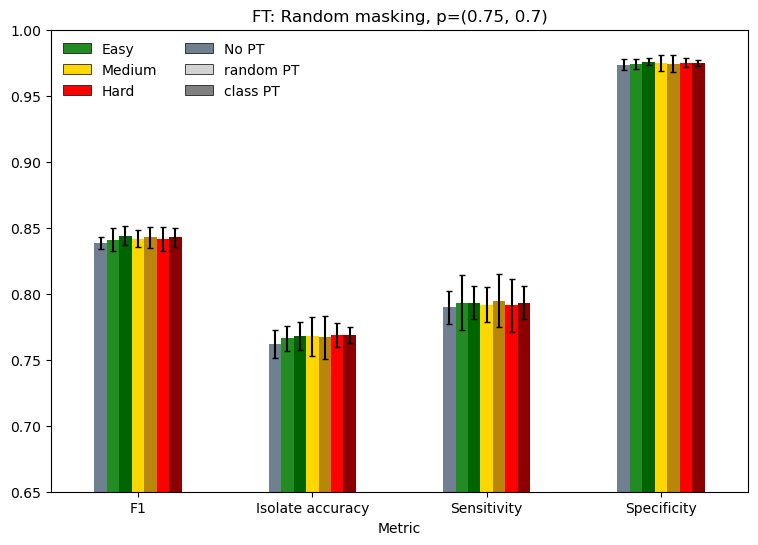

In [37]:
colors = ['slategray', 'forestgreen', 'darkgreen', 'gold', 'darkgoldenrod', 'red', 'darkred']
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.65, 1)
plt.xlabel('Metric')
plt.title('FT: Random masking, p=(0.75, 0.7)')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rnd0.7FT_abs_diff.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

## p = (0.75, 0.5)

In [38]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.75_0.5')

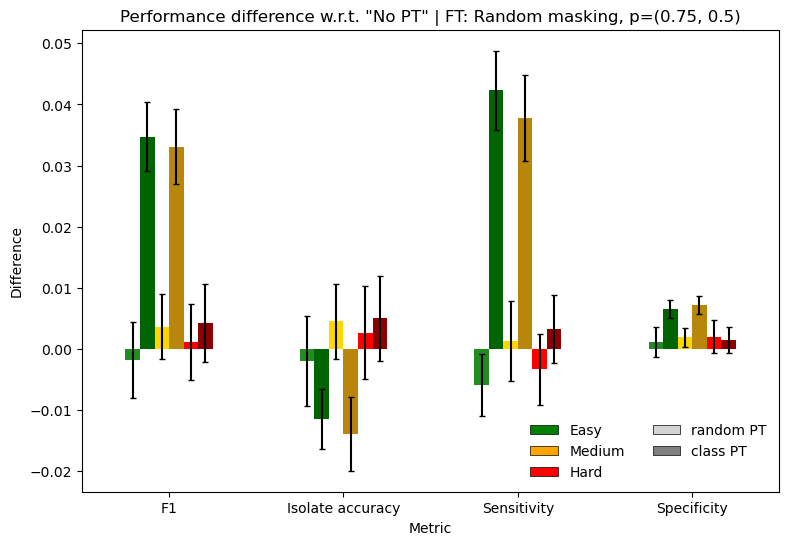

In [39]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('Performance difference w.r.t. "No PT" | FT: Random masking, p=(0.75, 0.5)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,  
    # loc='lower right',
)
# plt.ylim(-0.016, 0.03)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rnd0.5FT_rel_diff_w_error.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

## p = (0.75, 1 class)

In [40]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.75_class')

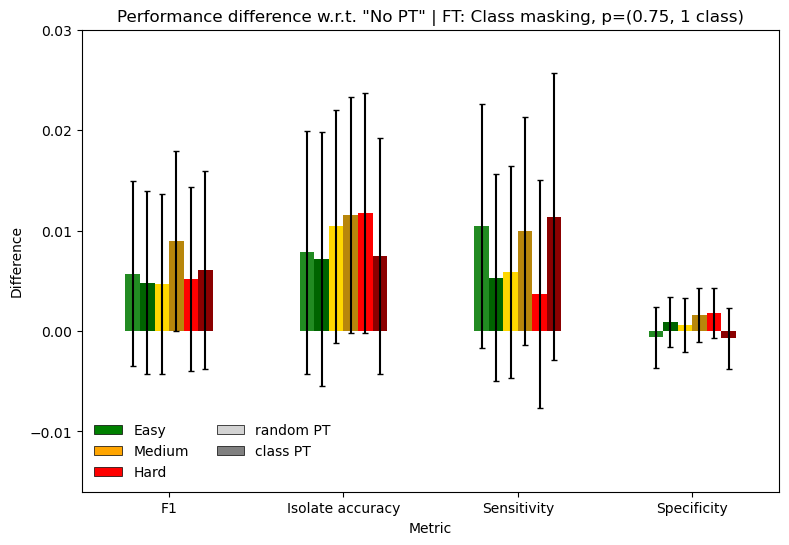

In [41]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('Performance difference w.r.t. "No PT" | FT: Class masking, p=(0.75, 1 class)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,  
    # loc='lower right',
)
plt.ylim(-0.016, 0.03)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rndFT_rel_diff_w_error.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

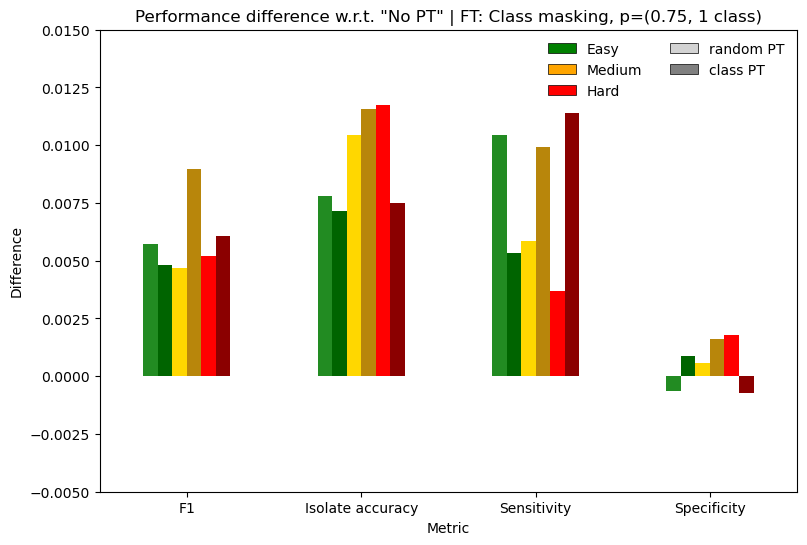

In [42]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', rot=0, figsize=(9, 6), color=colors[1:], ax=ax)
ax.set_title('Performance difference w.r.t. "No PT" | FT: Class masking, p=(0.75, 1 class)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,  
    # loc='lower right',
)
plt.ylim(-0.005, 0.015)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rndFT_rel_diff.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

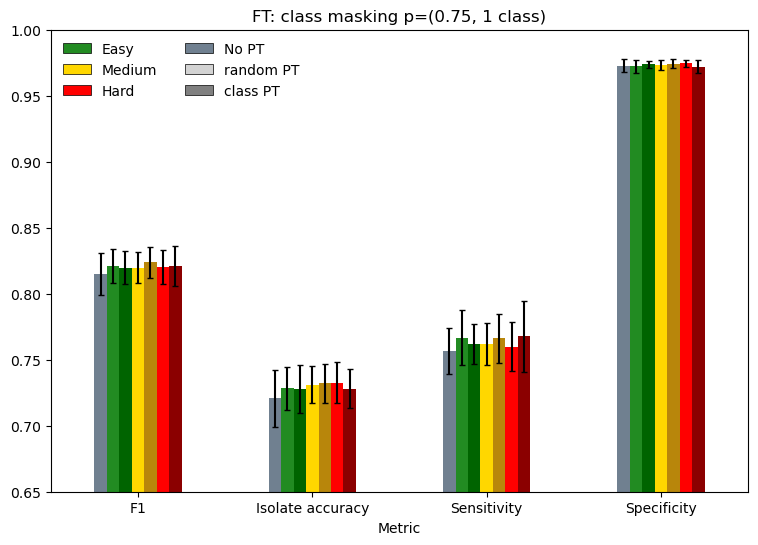

In [43]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.65, 1)
plt.xlabel('Metric')
plt.title('FT: class masking p=(0.75, 1 class)')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_abs_diff.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

# What happens with decreasing training size?

## Task: p = (0.75, 1 class)

Load results

In [44]:
def load_and_create_train_share_df(
    model_prefix: str,
    train_params: str,
    train_shares = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
):
    model_names = [f'{model_prefix}_{share}' for share in train_shares]
    results_dict_list = []
    for share in train_shares:
        results_dict_list.append(
            pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', f"FT_{model_prefix.replace(' ', '')}_{train_params}_train_share{share}", 'CV_results.pkl'))
        )
    df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
    df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
    df_CV = df_CV.reindex(columns=model_names, level=1)
    return df_CV

In [45]:
df_CV_noPT = load_and_create_train_share_df('No PT', '0.75_class')
df_CV_easyPT = load_and_create_train_share_df('Easy PT', '0.75_class')
df_CV_easyCPT = load_and_create_train_share_df('Easy CPT', '0.75_class')
df_CV_mediumPT = load_and_create_train_share_df('Medium PT', '0.75_class')
df_CV_mediumCPT = load_and_create_train_share_df('Medium CPT', '0.75_class')
df_CV_hardPT = load_and_create_train_share_df('Hard PT', '0.75_class')
df_CV_hardCPT = load_and_create_train_share_df('Hard CPT', '0.75_class')

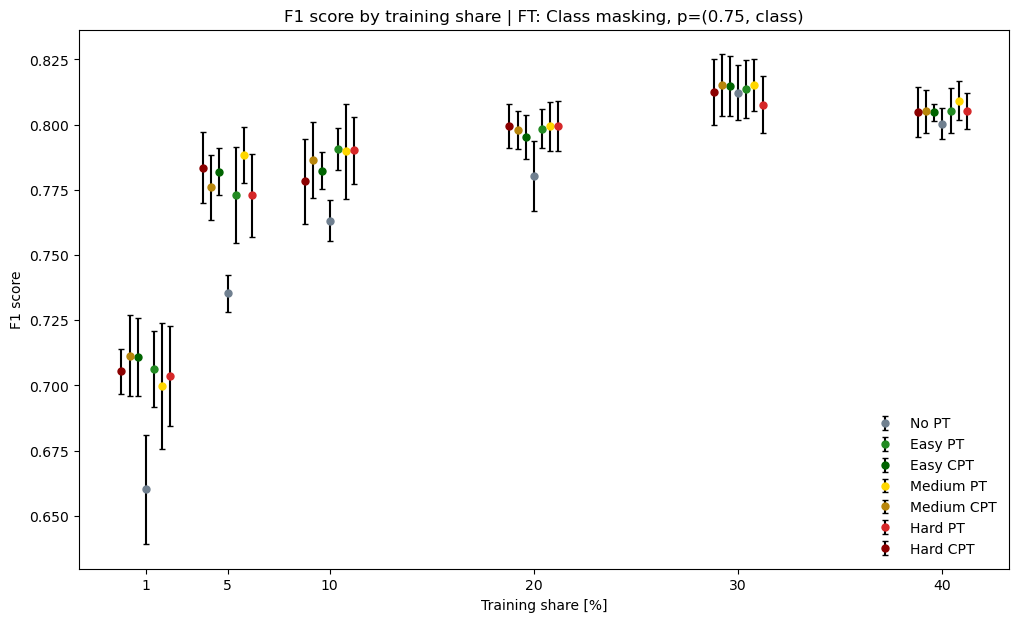

In [46]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['F1', 'avg'], yerr=df_CV_noPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['F1', 'avg'], yerr=df_CV_easyPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['F1', 'avg'], yerr=df_CV_easyCPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['F1', 'avg'], yerr=df_CV_mediumPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['F1', 'avg'], yerr=df_CV_mediumCPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['F1', 'avg'], yerr=df_CV_hardPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['F1', 'avg'], yerr=df_CV_hardCPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('F1 score by training share | FT: Class masking, p=(0.75, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('F1 score')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.75classFT_F1_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

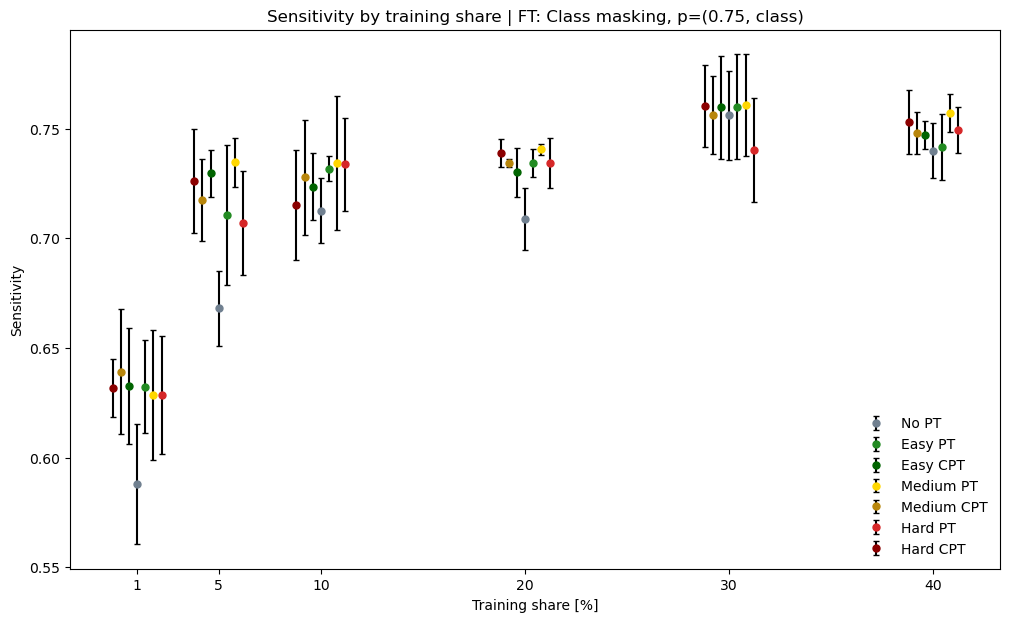

In [47]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['Sensitivity', 'avg'], yerr=df_CV_noPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['Sensitivity', 'avg'], yerr=df_CV_easyPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['Sensitivity', 'avg'], yerr=df_CV_easyCPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['Sensitivity', 'avg'], yerr=df_CV_mediumPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['Sensitivity', 'avg'], yerr=df_CV_mediumCPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['Sensitivity', 'avg'], yerr=df_CV_hardPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['Sensitivity', 'avg'], yerr=df_CV_hardCPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Sensitivity by training share | FT: Class masking, p=(0.75, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Sensitivity')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.75classFT_sens_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

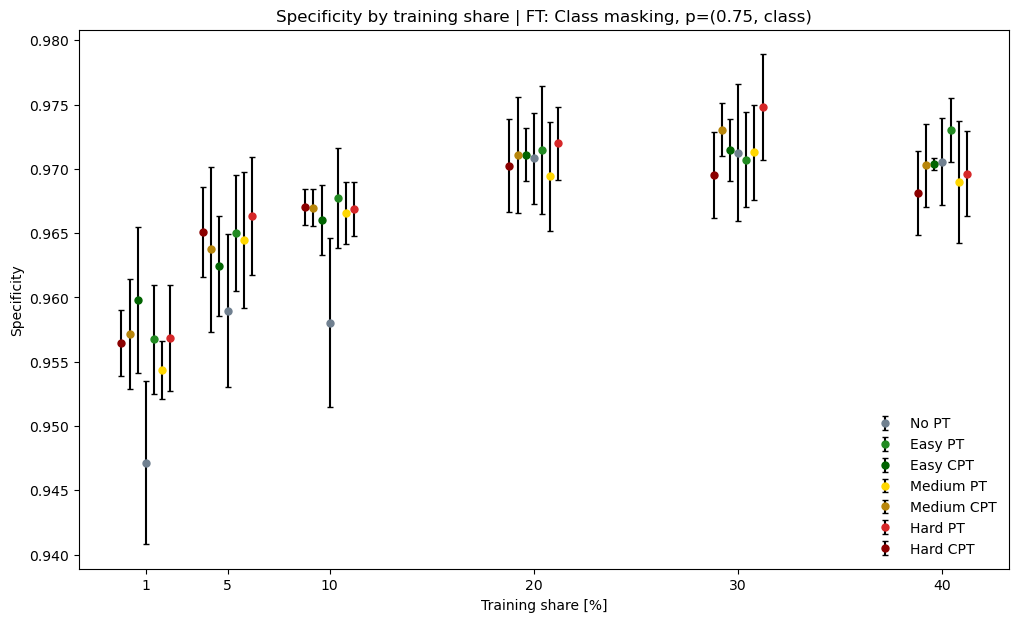

In [48]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['Specificity', 'avg'], yerr=df_CV_noPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['Specificity', 'avg'], yerr=df_CV_easyPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['Specificity', 'avg'], yerr=df_CV_easyCPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['Specificity', 'avg'], yerr=df_CV_mediumPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['Specificity', 'avg'], yerr=df_CV_mediumCPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['Specificity', 'avg'], yerr=df_CV_hardPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['Specificity', 'avg'], yerr=df_CV_hardCPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Specificity by training share | FT: Class masking, p=(0.75, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Specificity')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.75classFT_spec_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

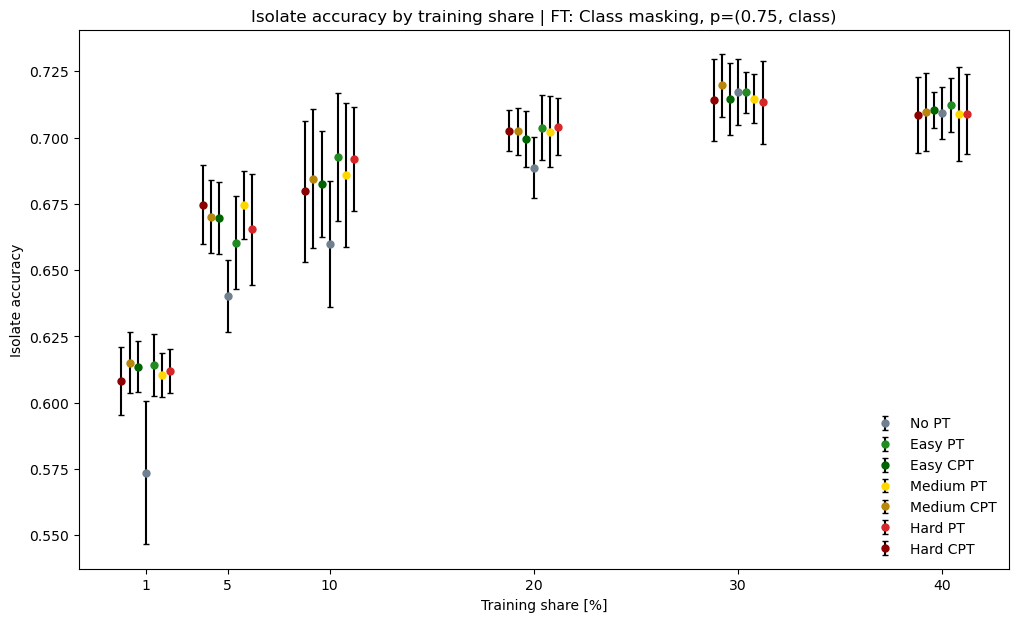

In [49]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_noPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_easyPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_easyCPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_mediumPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_mediumCPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_hardPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_hardCPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Isolate accuracy by training share | FT: Class masking, p=(0.75, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Isolate accuracy')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.75classFT_acc_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

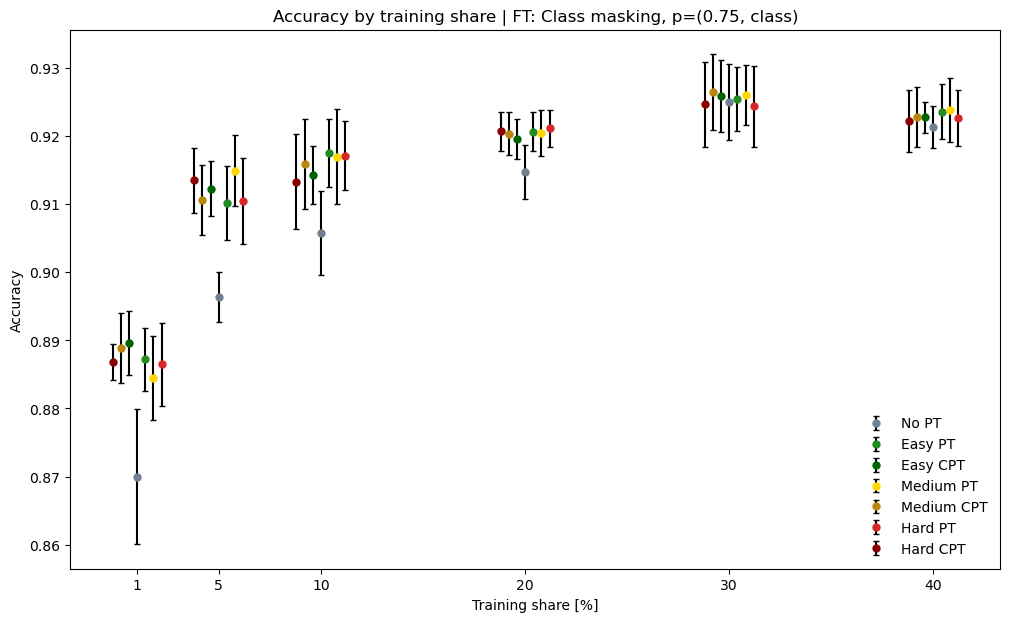

In [50]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['Accuracy', 'avg'], yerr=df_CV_noPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['Accuracy', 'avg'], yerr=df_CV_easyPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['Accuracy', 'avg'], yerr=df_CV_easyCPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['Accuracy', 'avg'], yerr=df_CV_mediumPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['Accuracy', 'avg'], yerr=df_CV_mediumCPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['Accuracy', 'avg'], yerr=df_CV_hardPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['Accuracy', 'avg'], yerr=df_CV_hardCPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Accuracy by training share | FT: Class masking, p=(0.75, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Accuracy')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.75classFT_acc_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

## Task: p = (0.75, 0.9)

In [51]:
df_CV_noPT = load_and_create_train_share_df('No PT', '0.75_0.9')
df_CV_easyPT = load_and_create_train_share_df('Easy PT', '0.75_0.9')
df_CV_easyCPT = load_and_create_train_share_df('Easy CPT', '0.75_0.9')
df_CV_mediumPT = load_and_create_train_share_df('Medium PT', '0.75_0.9')
df_CV_mediumCPT = load_and_create_train_share_df('Medium CPT', '0.75_0.9')
df_CV_hardPT = load_and_create_train_share_df('Hard PT', '0.75_0.9')
df_CV_hardCPT = load_and_create_train_share_df('Hard CPT', '0.75_0.9')

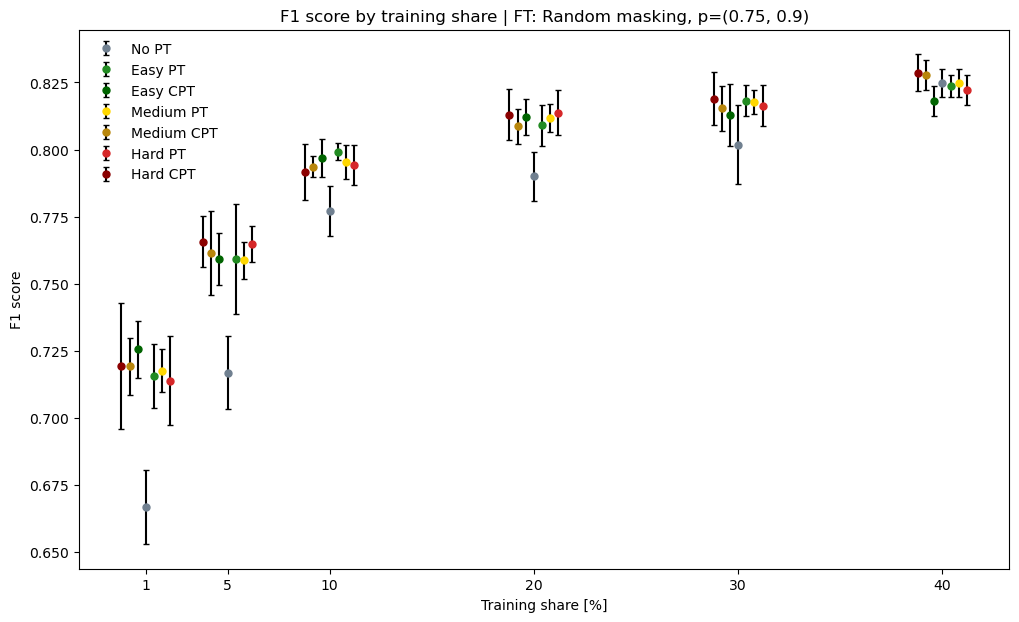

In [52]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['F1', 'avg'], yerr=df_CV_noPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['F1', 'avg'], yerr=df_CV_easyPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['F1', 'avg'], yerr=df_CV_easyCPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['F1', 'avg'], yerr=df_CV_mediumPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['F1', 'avg'], yerr=df_CV_mediumCPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['F1', 'avg'], yerr=df_CV_hardPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['F1', 'avg'], yerr=df_CV_hardCPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('F1 score by training share | FT: Random masking, p=(0.75, 0.9)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('F1 score')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.75_rnd0.9FT_F1_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

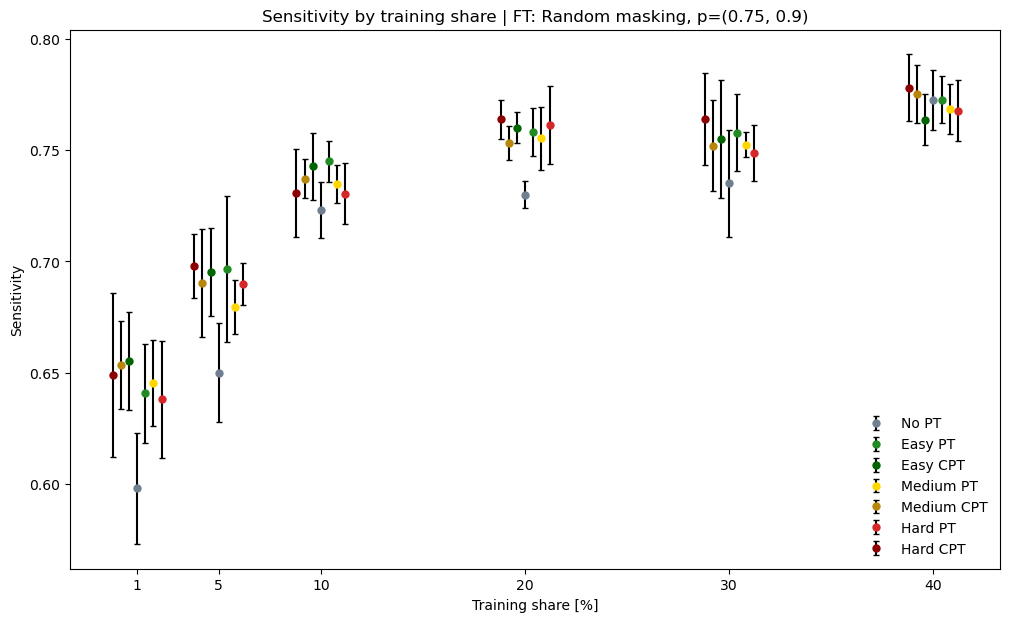

In [53]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['Sensitivity', 'avg'], yerr=df_CV_noPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['Sensitivity', 'avg'], yerr=df_CV_easyPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['Sensitivity', 'avg'], yerr=df_CV_easyCPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['Sensitivity', 'avg'], yerr=df_CV_mediumPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['Sensitivity', 'avg'], yerr=df_CV_mediumCPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['Sensitivity', 'avg'], yerr=df_CV_hardPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['Sensitivity', 'avg'], yerr=df_CV_hardCPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Sensitivity by training share | FT: Random masking, p=(0.75, 0.9)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Sensitivity')
ax.set_xticks(train_shares)
ax.legend(framealpha=0, loc='lower right')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.75rnd0.9FT_sens_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

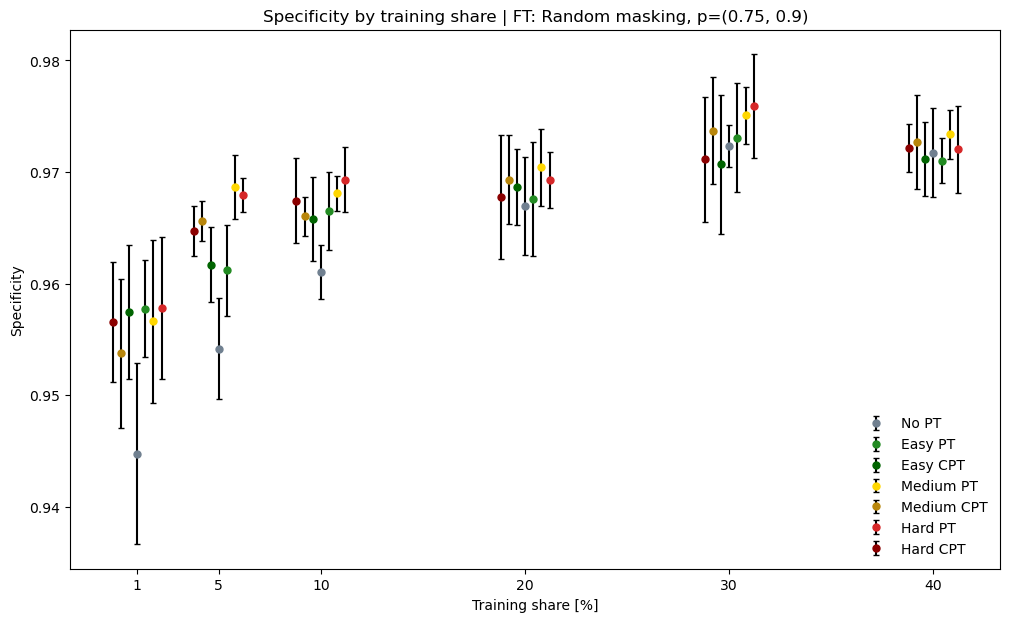

In [54]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['Specificity', 'avg'], yerr=df_CV_noPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['Specificity', 'avg'], yerr=df_CV_easyPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['Specificity', 'avg'], yerr=df_CV_easyCPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['Specificity', 'avg'], yerr=df_CV_mediumPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['Specificity', 'avg'], yerr=df_CV_mediumCPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['Specificity', 'avg'], yerr=df_CV_hardPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['Specificity', 'avg'], yerr=df_CV_hardCPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Specificity by training share | FT: Random masking, p=(0.75, 0.9)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Specificity')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.75rnd0.9FT_spec_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

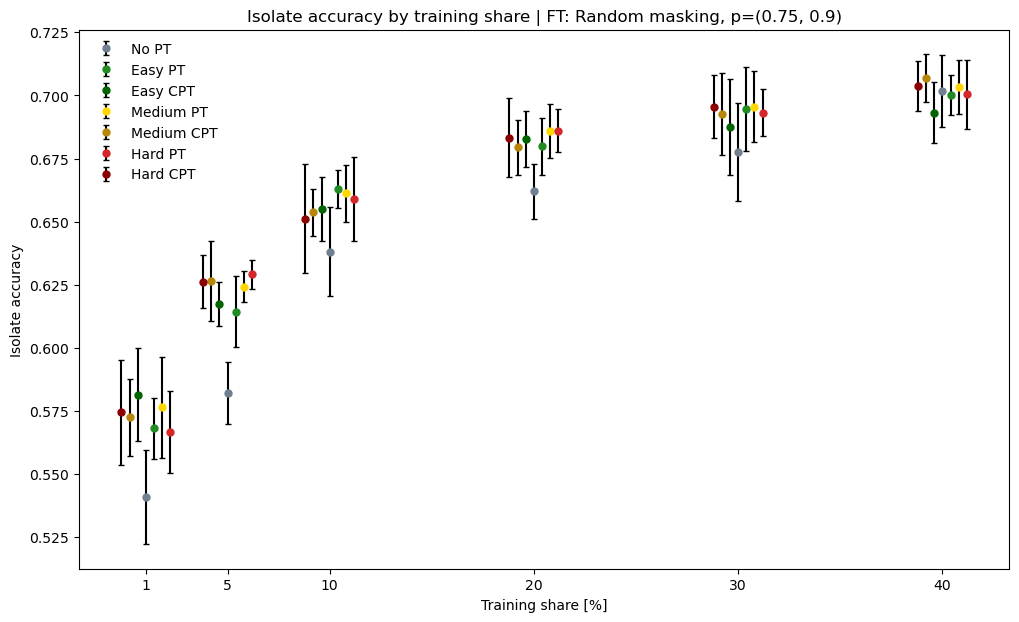

In [55]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_noPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_easyPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_easyCPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_mediumPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_mediumCPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_hardPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_hardCPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Isolate accuracy by training share | FT: Random masking, p=(0.75, 0.9)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Isolate accuracy')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.75rnd0.9FT_acc_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

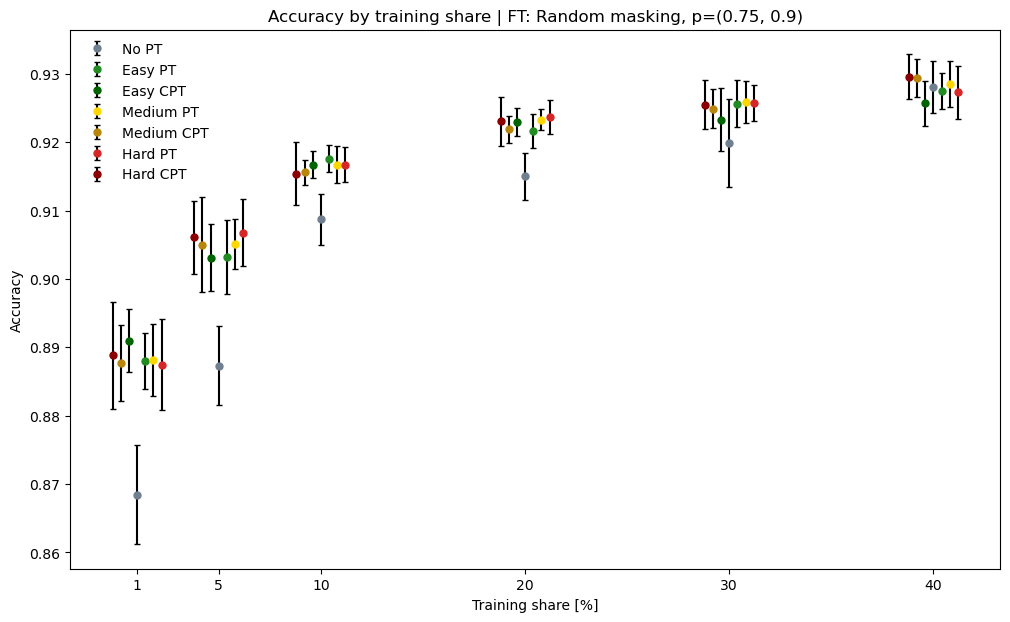

In [56]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['Accuracy', 'avg'], yerr=df_CV_noPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['Accuracy', 'avg'], yerr=df_CV_easyPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['Accuracy', 'avg'], yerr=df_CV_easyCPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['Accuracy', 'avg'], yerr=df_CV_mediumPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['Accuracy', 'avg'], yerr=df_CV_mediumCPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['Accuracy', 'avg'], yerr=df_CV_hardPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['Accuracy', 'avg'], yerr=df_CV_hardCPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Accuracy by training share | FT: Random masking, p=(0.75, 0.9)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Accuracy')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.75rnd0.9FT_acc_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

## Task: p = (0.5, 0.7)

In [57]:
df_CV_noPT = load_and_create_train_share_df('No PT', '0.5_0.7')
df_CV_easyPT = load_and_create_train_share_df('Easy PT', '0.5_0.7')
df_CV_easyCPT = load_and_create_train_share_df('Easy CPT', '0.5_0.7')
df_CV_mediumPT = load_and_create_train_share_df('Medium PT', '0.5_0.7')
df_CV_mediumCPT = load_and_create_train_share_df('Medium CPT', '0.5_0.7')
df_CV_hardPT = load_and_create_train_share_df('Hard PT', '0.5_0.7')
df_CV_hardCPT = load_and_create_train_share_df('Hard CPT', '0.5_0.7')

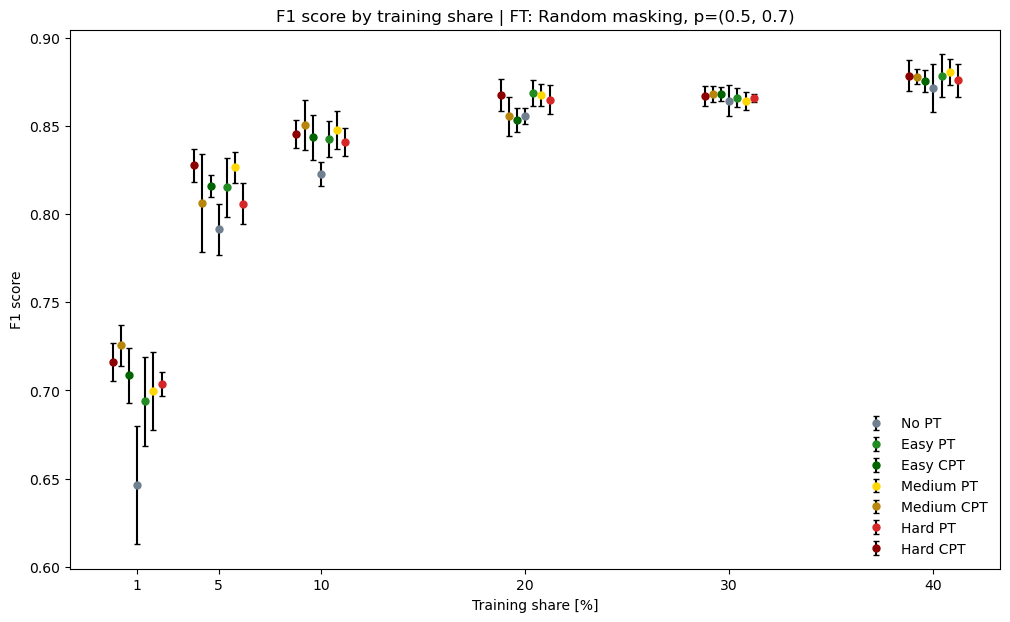

In [58]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['F1', 'avg'], yerr=df_CV_noPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['F1', 'avg'], yerr=df_CV_easyPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['F1', 'avg'], yerr=df_CV_easyCPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['F1', 'avg'], yerr=df_CV_mediumPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['F1', 'avg'], yerr=df_CV_mediumCPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['F1', 'avg'], yerr=df_CV_hardPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['F1', 'avg'], yerr=df_CV_hardCPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('F1 score by training share | FT: Random masking, p=(0.5, 0.7)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('F1 score')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.5_rnd0.7FT_F1_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

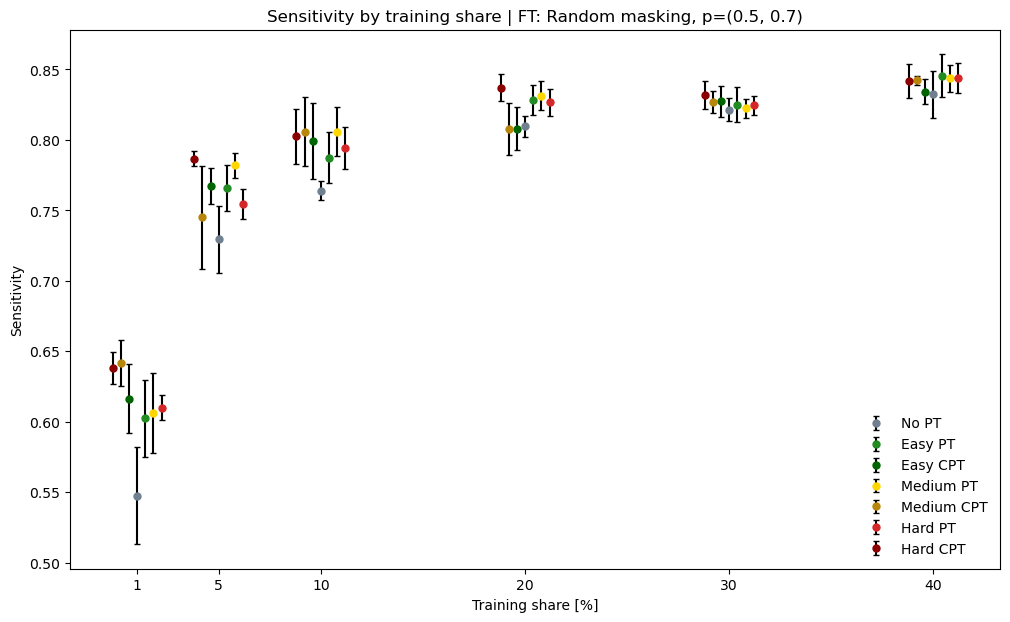

In [59]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['Sensitivity', 'avg'], yerr=df_CV_noPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['Sensitivity', 'avg'], yerr=df_CV_easyPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['Sensitivity', 'avg'], yerr=df_CV_easyCPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['Sensitivity', 'avg'], yerr=df_CV_mediumPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['Sensitivity', 'avg'], yerr=df_CV_mediumCPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['Sensitivity', 'avg'], yerr=df_CV_hardPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['Sensitivity', 'avg'], yerr=df_CV_hardCPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Sensitivity by training share | FT: Random masking, p=(0.5, 0.7)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Sensitivity')
ax.set_xticks(train_shares)
ax.legend(framealpha=0, loc='lower right')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.5rnd0.7FT_sens_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

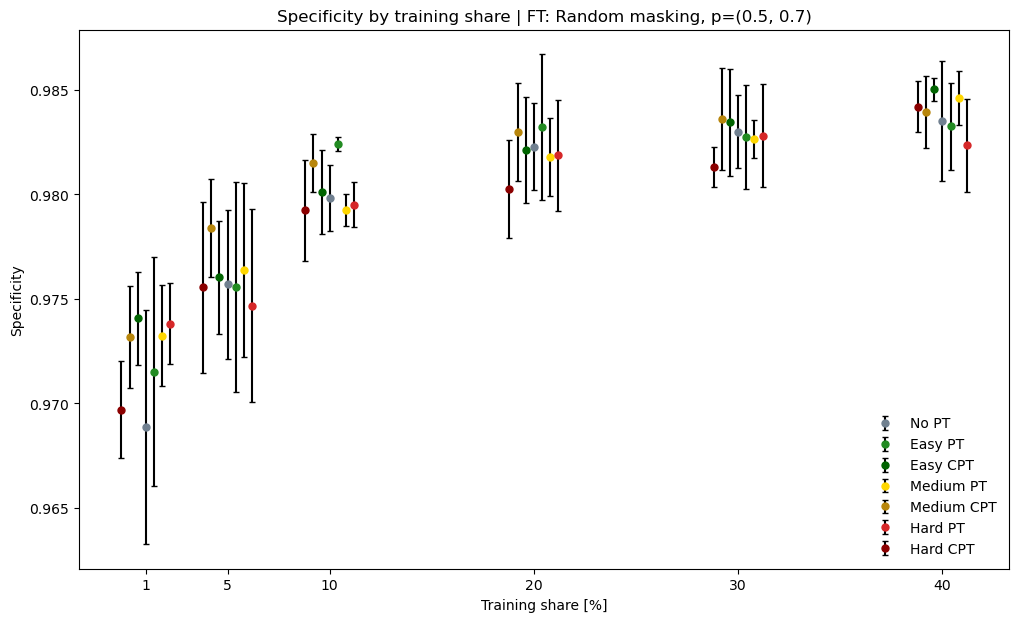

In [60]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['Specificity', 'avg'], yerr=df_CV_noPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['Specificity', 'avg'], yerr=df_CV_easyPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['Specificity', 'avg'], yerr=df_CV_easyCPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['Specificity', 'avg'], yerr=df_CV_mediumPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['Specificity', 'avg'], yerr=df_CV_mediumCPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['Specificity', 'avg'], yerr=df_CV_hardPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['Specificity', 'avg'], yerr=df_CV_hardCPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Specificity by training share | FT: Random masking, p=(0.5, 0.7)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Specificity')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.5rnd0.7FT_spec_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

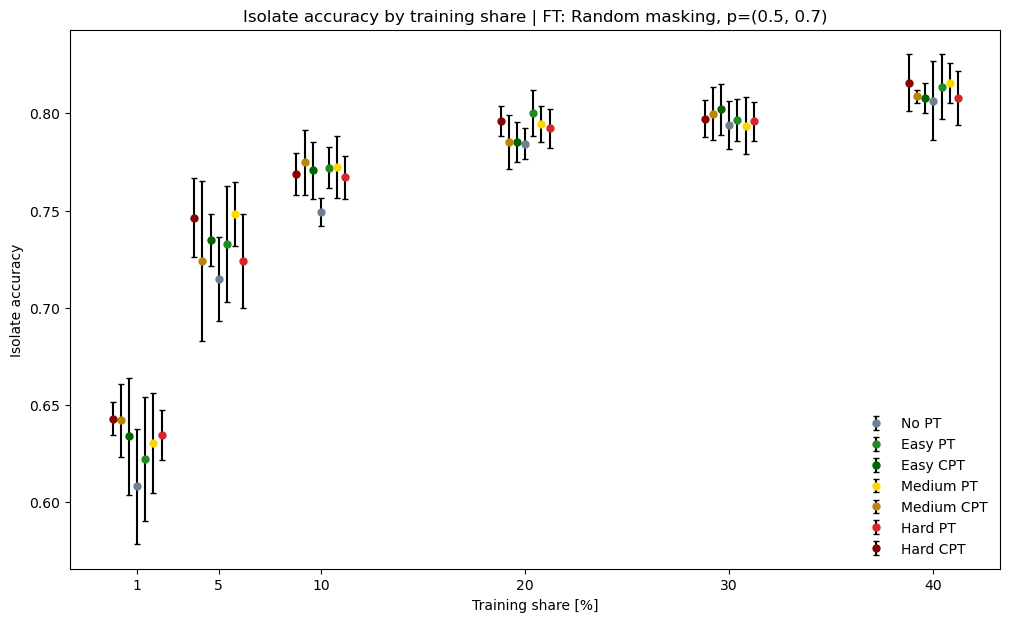

In [61]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_noPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_easyPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_easyCPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_mediumPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_mediumCPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_hardPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['Isolate accuracy', 'avg'], yerr=df_CV_hardCPT.loc['Isolate accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Isolate accuracy by training share | FT: Random masking, p=(0.5, 0.7)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Isolate accuracy')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.5rnd0.7FT_acc_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

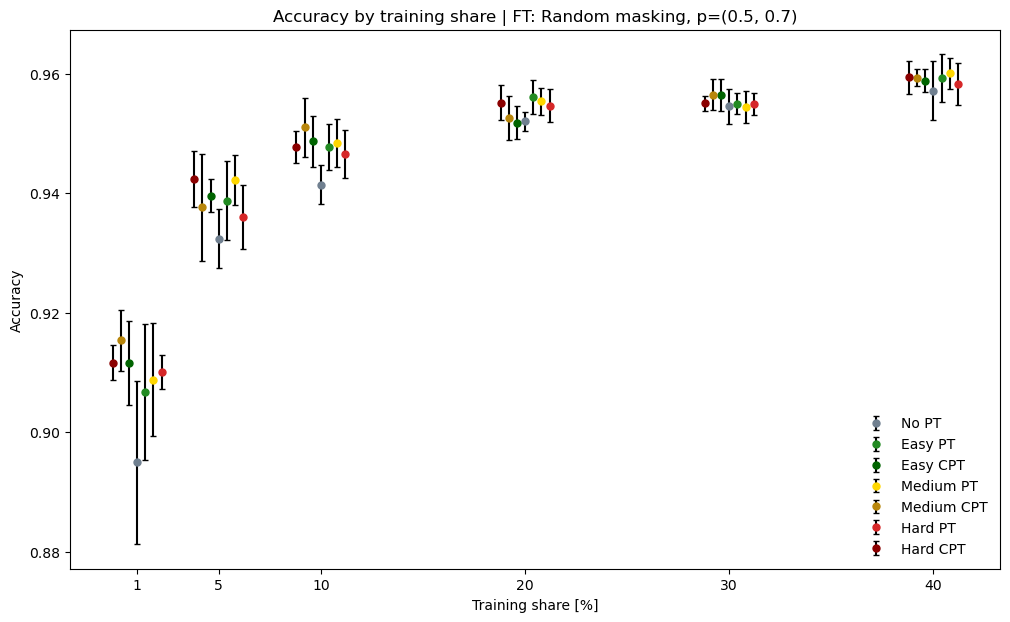

In [62]:
train_shares = [1, 5, 10, 20, 30, 40] # in percent
_, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(train_shares, df_CV_noPT.loc['Accuracy', 'avg'], yerr=df_CV_noPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_easyPT.loc['Accuracy', 'avg'], yerr=df_CV_easyPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='forestgreen', label='Easy PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_easyCPT.loc['Accuracy', 'avg'], yerr=df_CV_easyCPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgreen', label='Easy CPT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_mediumPT.loc['Accuracy', 'avg'], yerr=df_CV_mediumPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumCPT.loc['Accuracy', 'avg'], yerr=df_CV_mediumCPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+1.2 for s in train_shares], df_CV_hardPT.loc['Accuracy', 'avg'], yerr=df_CV_hardPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s-1.2 for s in train_shares], df_CV_hardCPT.loc['Accuracy', 'avg'], yerr=df_CV_hardCPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Accuracy by training share | FT: Random masking, p=(0.5, 0.7)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Accuracy')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', '0.5rnd0.7FT_acc_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

## Plot differences for each metric at specific train_shares (1%, 10%, 30%)

### TS = 1%

FT: Random masking, p=(0.75,0.9)

In [63]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.75_0.9', '0.01')

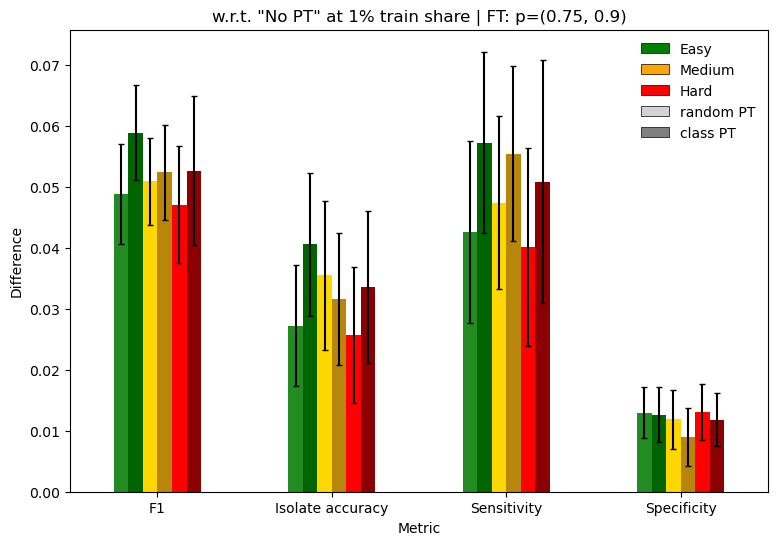

In [64]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('w.r.t. "No PT" at 1% train share | FT: p=(0.75, 0.9)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=1,
    framealpha=0, 
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_rel_diff_w_error_0.01.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

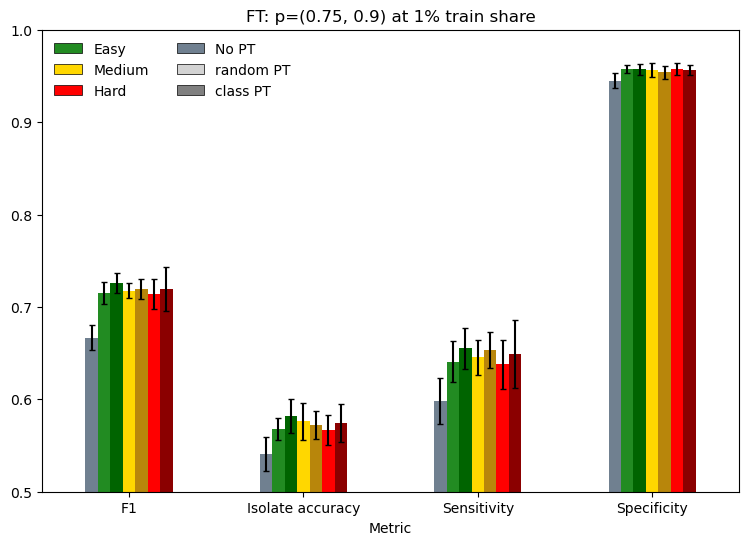

In [65]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.5, 1)
plt.xlabel('Metric')
plt.title('FT: p=(0.75, 0.9) at 1% train share')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_abs_diff_0.01.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

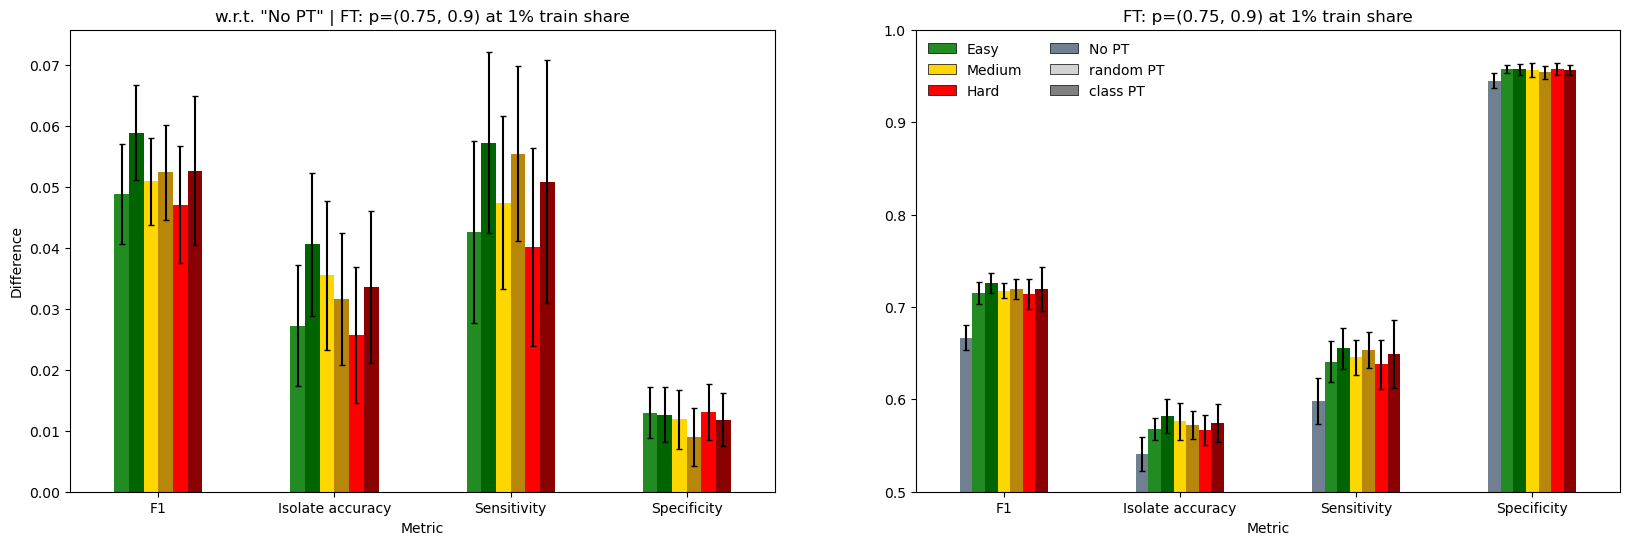

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_title('w.r.t. "No PT" | FT: p=(0.75, 0.9) at 1% train share')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax2.legend(
    handles=[easyPT, mediumPT, hardPT, noPT, pt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')
ax2.set_title('FT: p=(0.75, 0.9) at 1% train share')

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_diff_0.01.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()


FT: Random masking, p=(0.5,0.7)

In [67]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.5_0.7', '0.01')

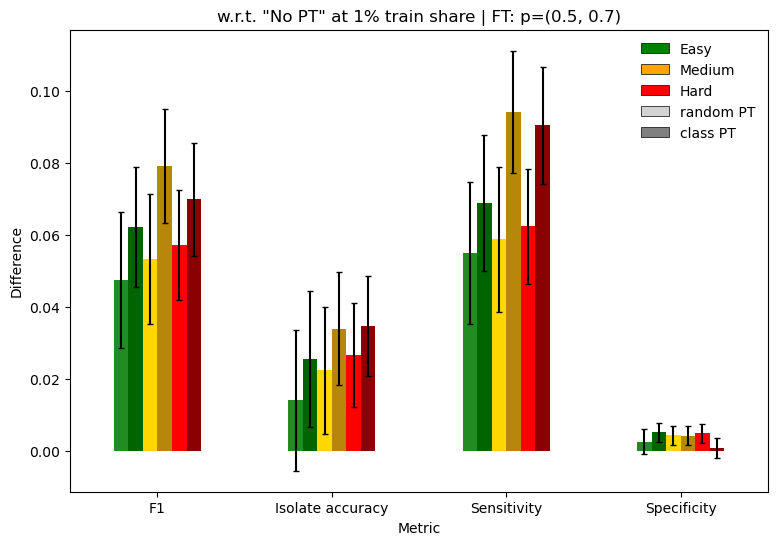

In [68]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('w.r.t. "No PT" at 1% train share | FT: p=(0.5, 0.7)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=1,
    framealpha=0, 
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_0.5_0.7_rel_diff_w_error_0.01.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

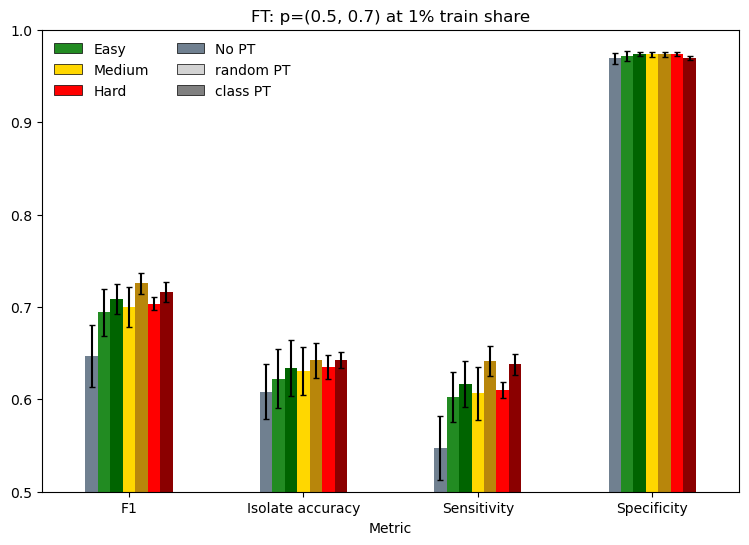

In [69]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.5, 1)
plt.xlabel('Metric')
plt.title('FT: p=(0.5, 0.7) at 1% train share')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_0.5_0.7_abs_diff_0.01.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

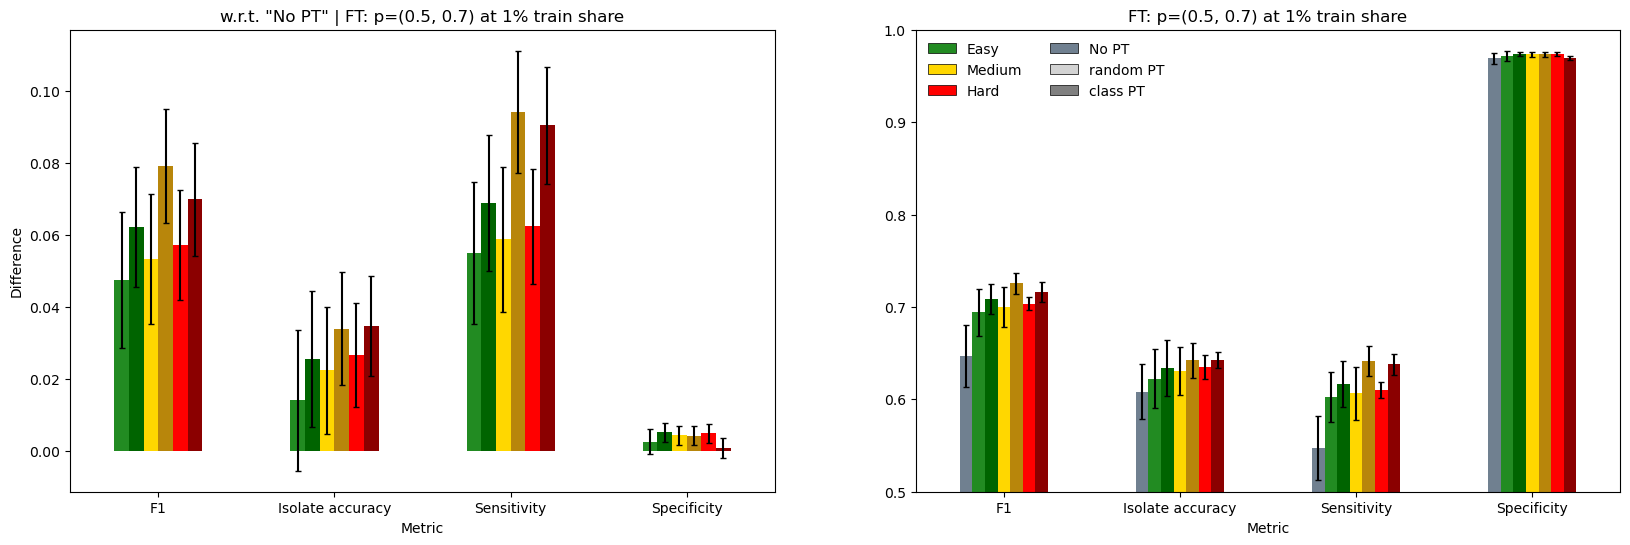

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_title('w.r.t. "No PT" | FT: p=(0.5, 0.7) at 1% train share')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax2.legend(
    handles=[easyPT, mediumPT, hardPT, noPT, pt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')
ax2.set_title('FT: p=(0.5, 0.7) at 1% train share')

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_0.5_0.7_diff_0.01.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()


FT: Class masking

In [71]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.75_class', '0.01')

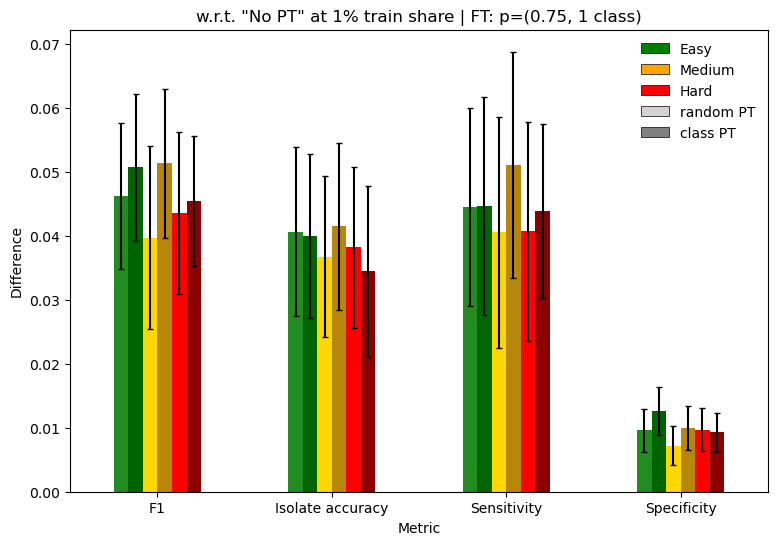

In [72]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('w.r.t. "No PT" at 1% train share | FT: p=(0.75, 1 class)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=1,
    framealpha=0, 
    # loc='lower right',
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_rel_diff_w_error_0.01.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

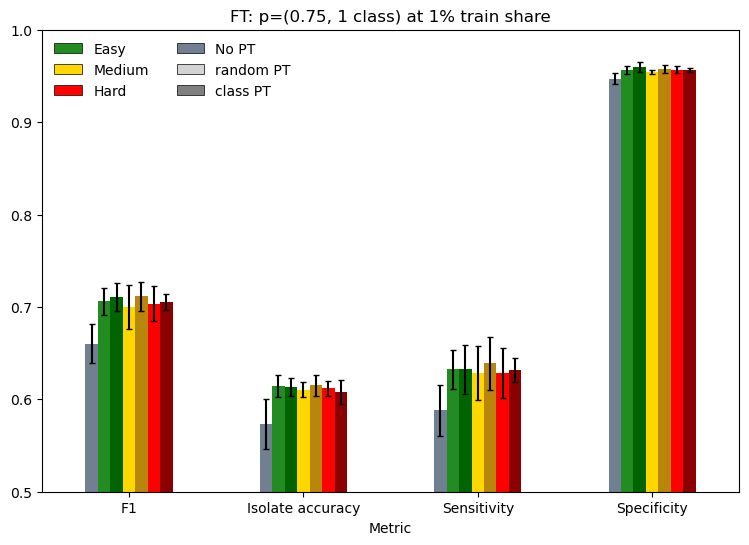

In [73]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.5, 1)
plt.xlabel('Metric')
plt.title('FT: p=(0.75, 1 class) at 1% train share')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_abs_diff_0.01.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

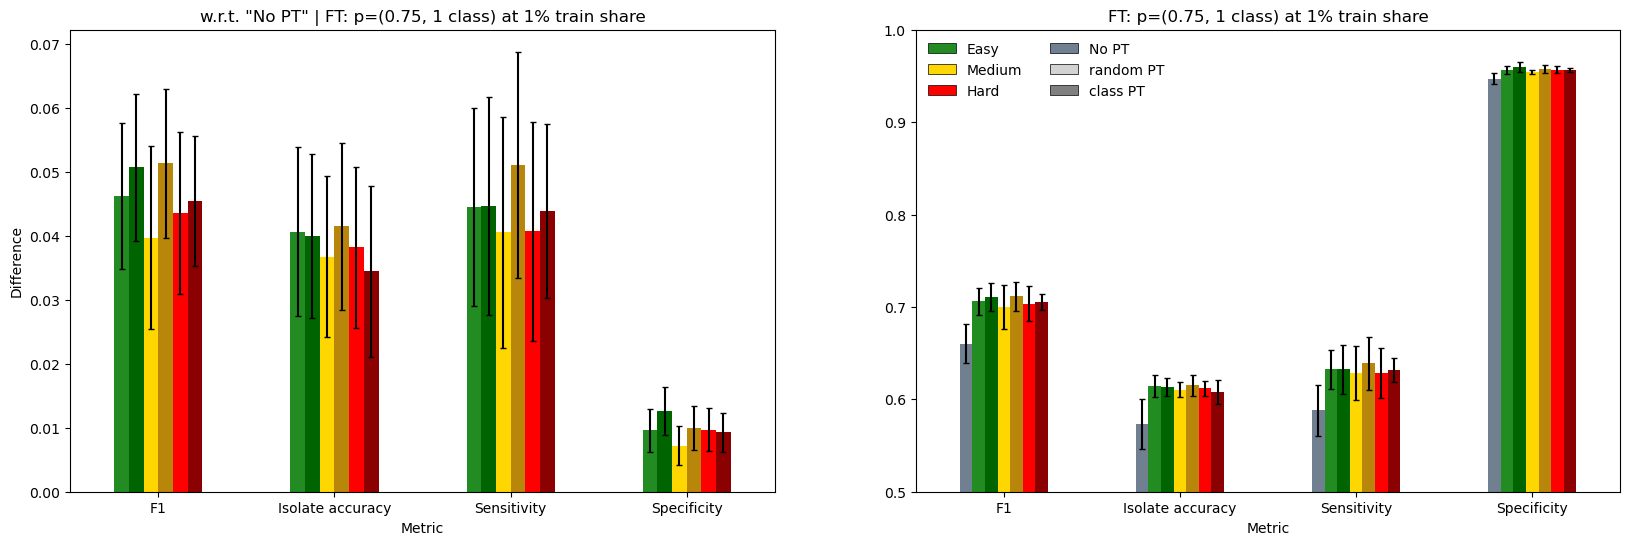

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_title('w.r.t. "No PT" | FT: p=(0.75, 1 class) at 1% train share')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax2.legend(
    handles=[easyPT, mediumPT, hardPT, noPT, pt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')
ax2.set_title('FT: p=(0.75, 1 class) at 1% train share')

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_diff_0.01.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()


### TS = 5%

FT: Random masking, p=(0.75,0.9)

In [75]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.75_0.9', '0.05')

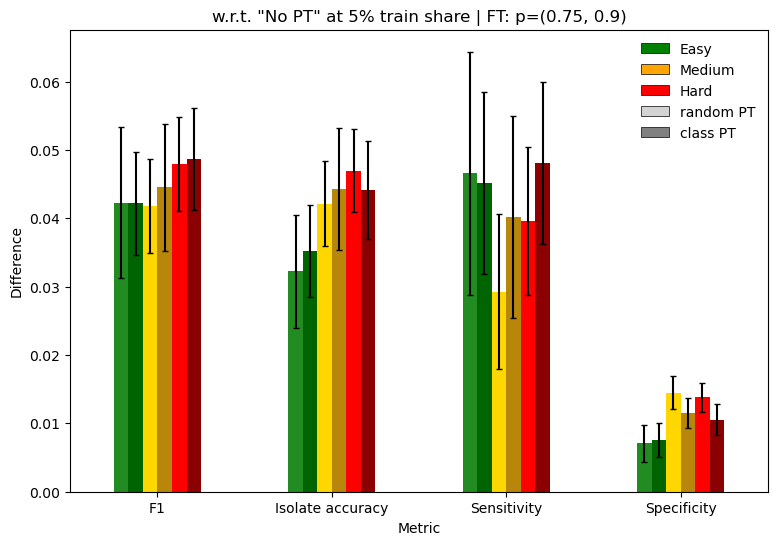

In [76]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('w.r.t. "No PT" at 5% train share | FT: p=(0.75, 0.9)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=1,
    framealpha=0, 
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_rel_diff_w_error_0.05.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

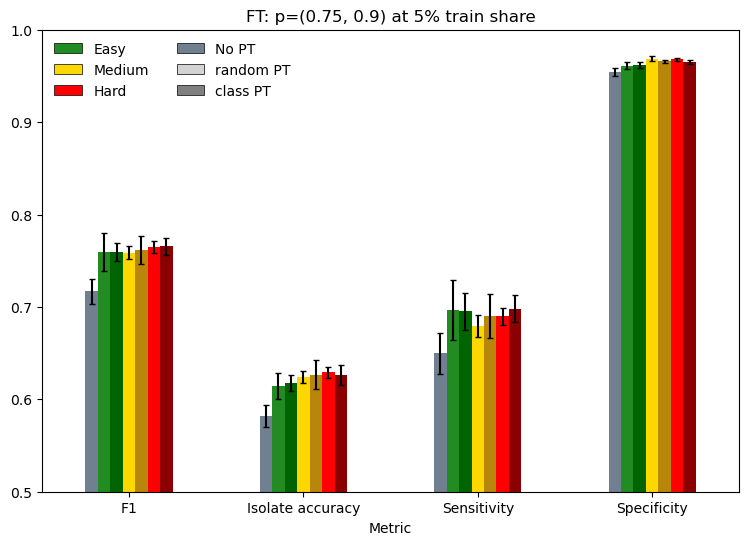

In [77]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.5, 1)
plt.xlabel('Metric')
plt.title('FT: p=(0.75, 0.9) at 5% train share')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_abs_diff_0.05.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

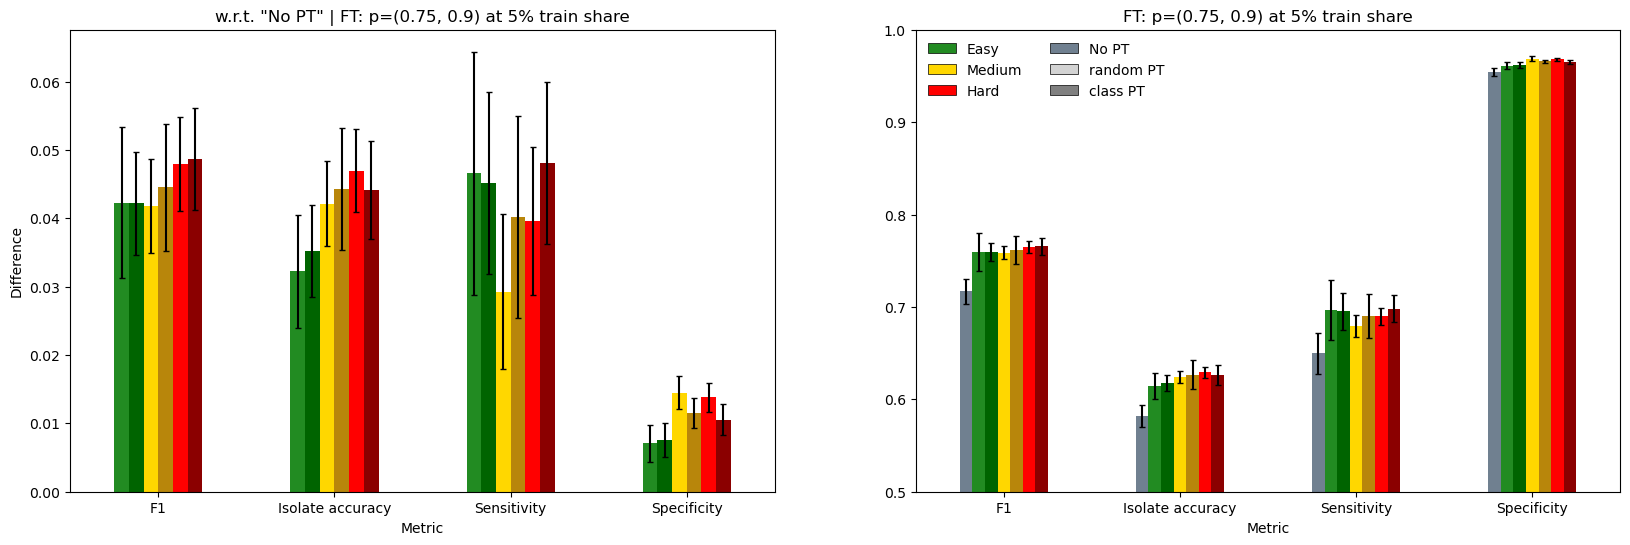

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_title('w.r.t. "No PT" | FT: p=(0.75, 0.9) at 5% train share')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax2.legend(
    handles=[easyPT, mediumPT, hardPT, noPT, pt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')
ax2.set_title('FT: p=(0.75, 0.9) at 5% train share')

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_diff_0.05.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

FT: Random masking, p=(0.5,0.7)

In [79]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.5_0.7', '0.05')

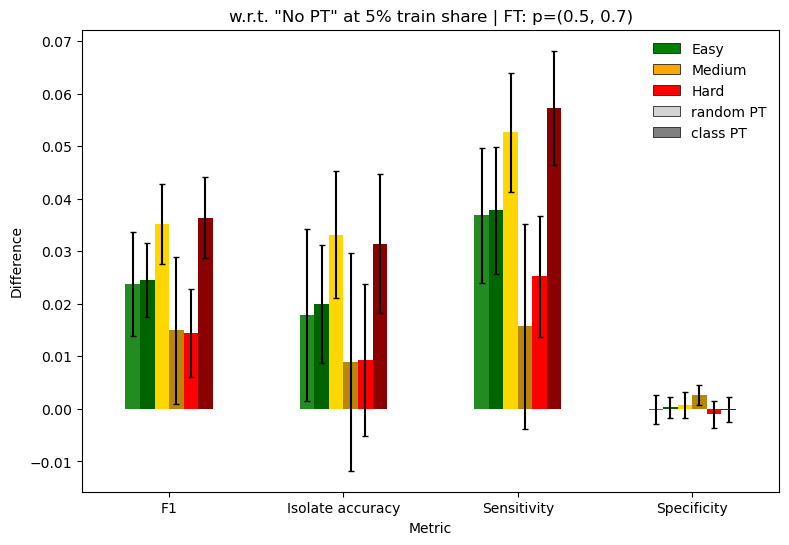

In [80]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('w.r.t. "No PT" at 5% train share | FT: p=(0.5, 0.7)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=1,
    framealpha=0, 
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_0.5_0.7_rel_diff_w_error_0.05.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

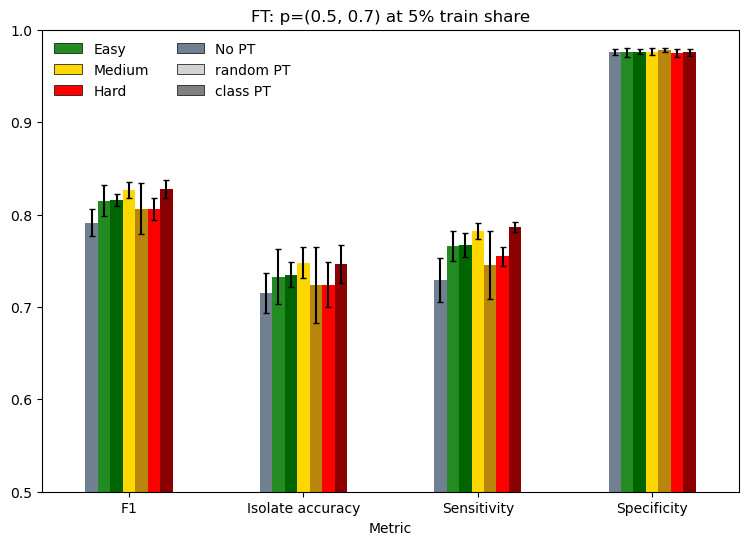

In [81]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.5, 1)
plt.xlabel('Metric')
plt.title('FT: p=(0.5, 0.7) at 5% train share')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_0.5_0.7_abs_diff_0.05.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

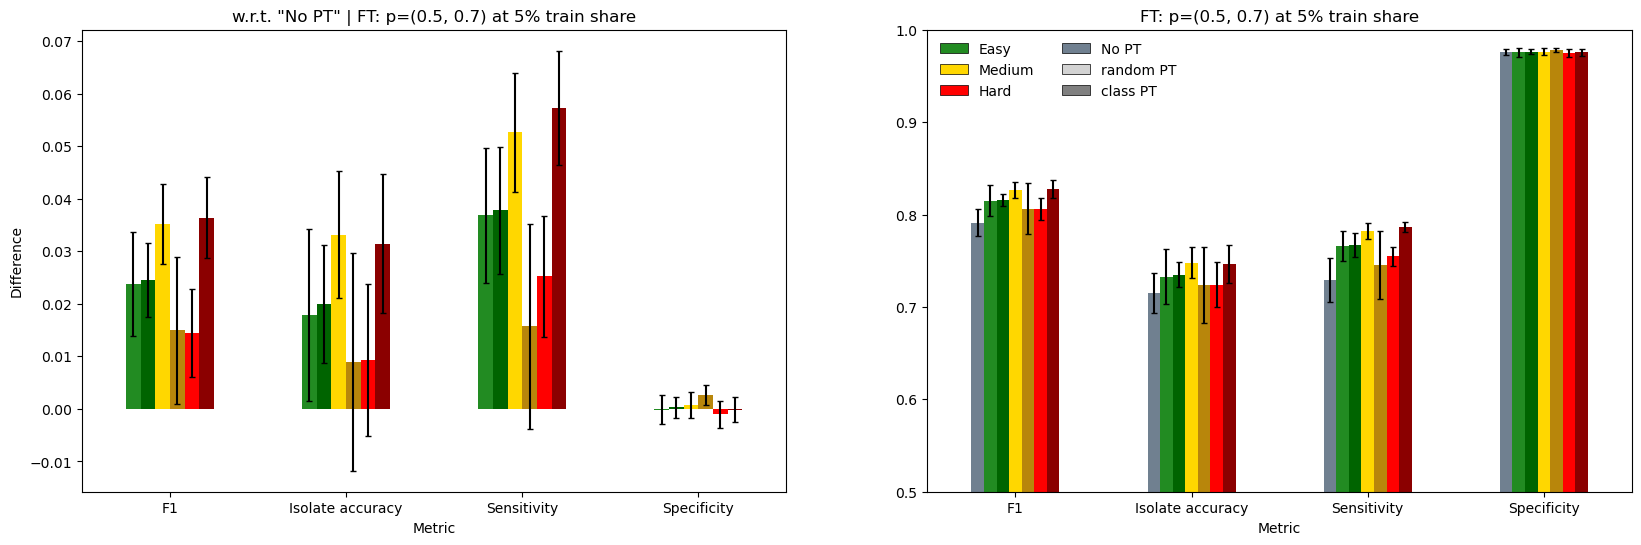

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_title('w.r.t. "No PT" | FT: p=(0.5, 0.7) at 5% train share')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax2.legend(
    handles=[easyPT, mediumPT, hardPT, noPT, pt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')
ax2.set_title('FT: p=(0.5, 0.7) at 5% train share')

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_0.5_0.7_diff_0.05.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

FT: Class masking

In [83]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.75_class', '0.05')

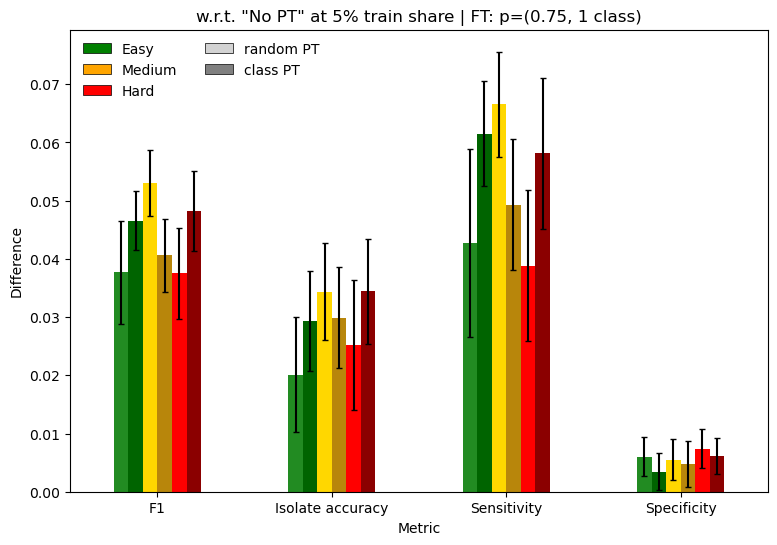

In [84]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('w.r.t. "No PT" at 5% train share | FT: p=(0.75, 1 class)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0, 
    # loc='lower right',
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_rel_diff_w_error_0.05.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

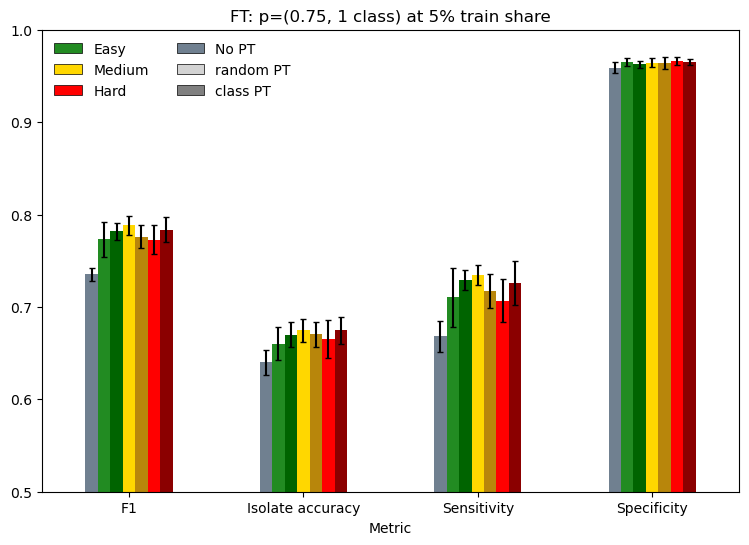

In [85]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.5, 1)
plt.xlabel('Metric')
plt.title('FT: p=(0.75, 1 class) at 5% train share')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_abs_diff_0.05.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

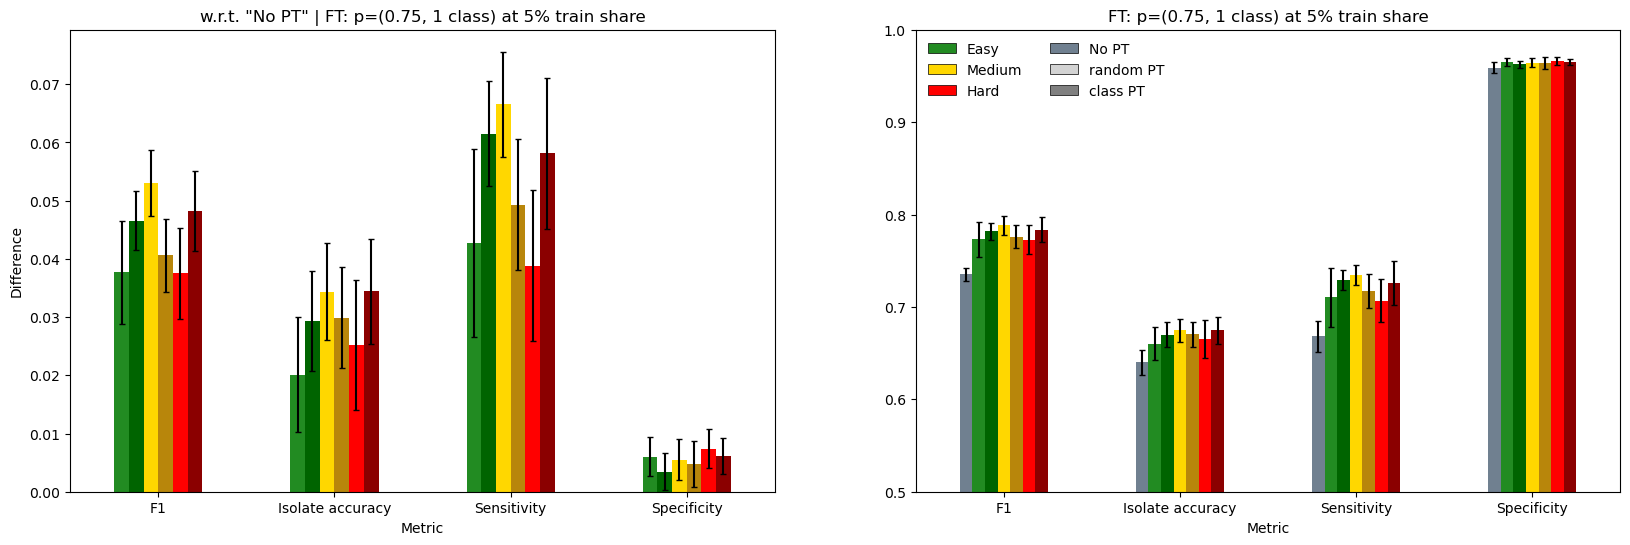

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_title('w.r.t. "No PT" | FT: p=(0.75, 1 class) at 5% train share')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax2.legend(
    handles=[easyPT, mediumPT, hardPT, noPT, pt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')
ax2.set_title('FT: p=(0.75, 1 class) at 5% train share')

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_diff_0.05.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()


### TS = 10%

FT: Random masking, p=(0.75,0.9)

In [87]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.75_0.9', '0.1')

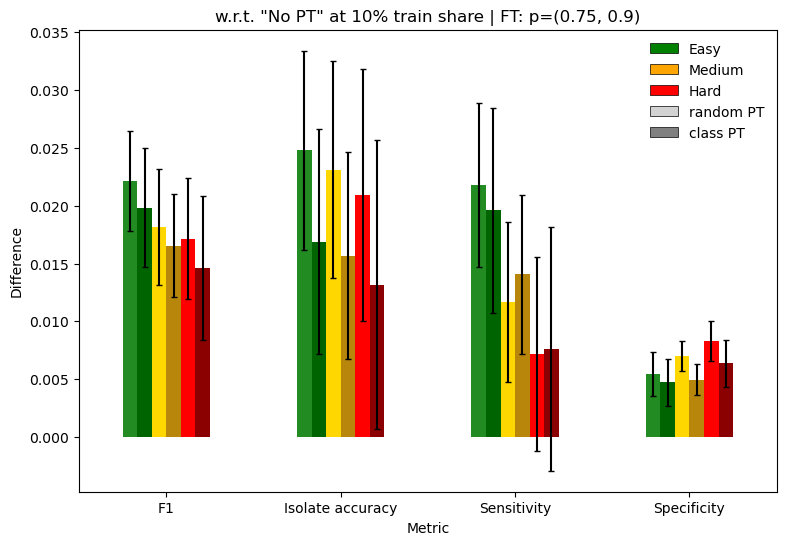

In [88]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('w.r.t. "No PT" at 10% train share | FT: p=(0.75, 0.9)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=1,
    framealpha=0, 
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_rel_diff_w_error_0.1.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

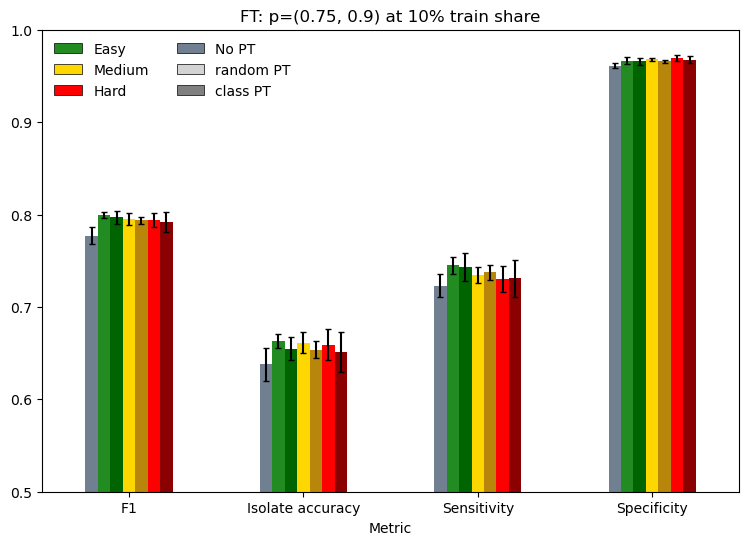

In [89]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.5, 1)
plt.xlabel('Metric')
plt.title('FT: p=(0.75, 0.9) at 10% train share')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_abs_diff_0.1.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

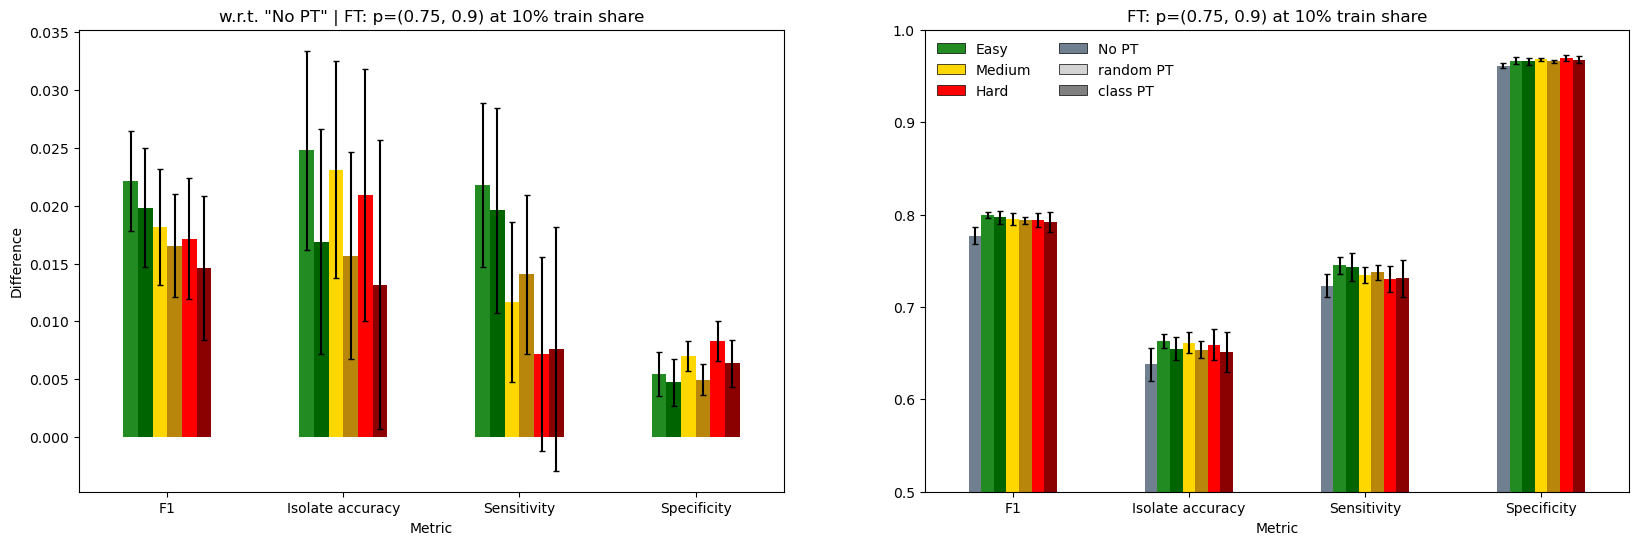

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_title('w.r.t. "No PT" | FT: p=(0.75, 0.9) at 10% train share')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax2.legend(
    handles=[easyPT, mediumPT, hardPT, noPT, pt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')
ax2.set_title('FT: p=(0.75, 0.9) at 10% train share')

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_diff_0.1.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()


FT: Random masking, p=(0.5,0.7)

In [91]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.5_0.7', '0.1')

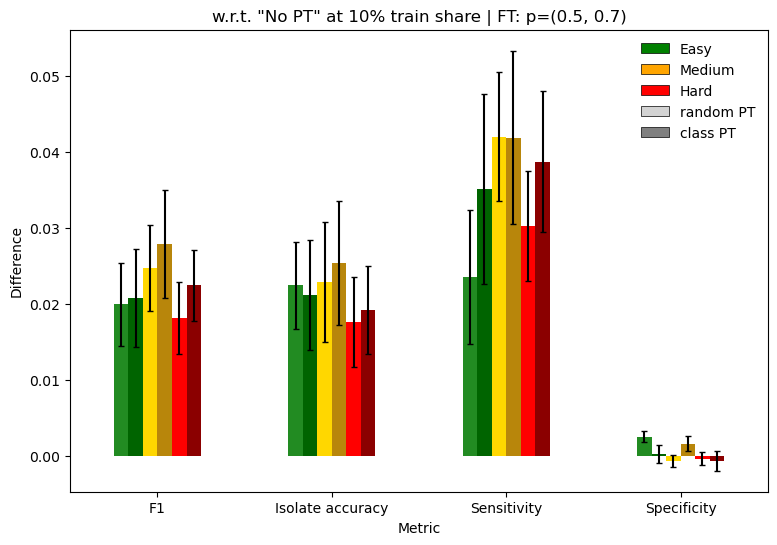

In [92]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('w.r.t. "No PT" at 10% train share | FT: p=(0.5, 0.7)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=1,
    framealpha=0, 
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_0.5_0.7_rel_diff_w_error_0.1.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

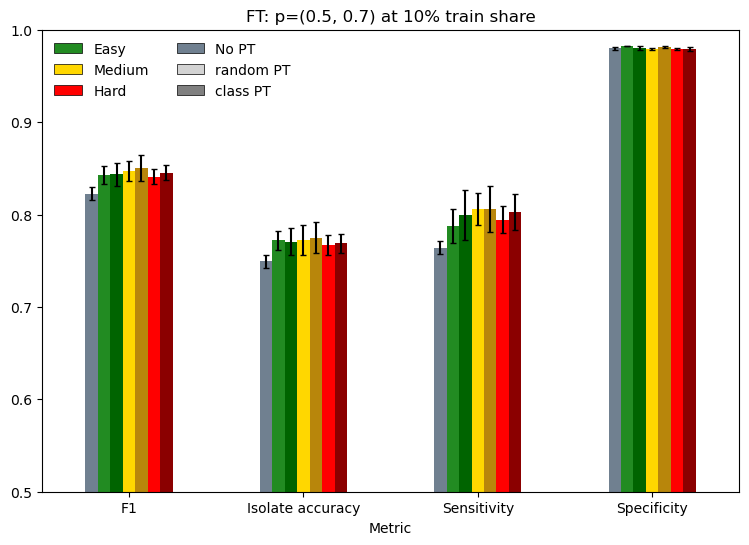

In [93]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.5, 1)
plt.xlabel('Metric')
plt.title('FT: p=(0.5, 0.7) at 10% train share')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_0.5_0.7_abs_diff_0.1.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

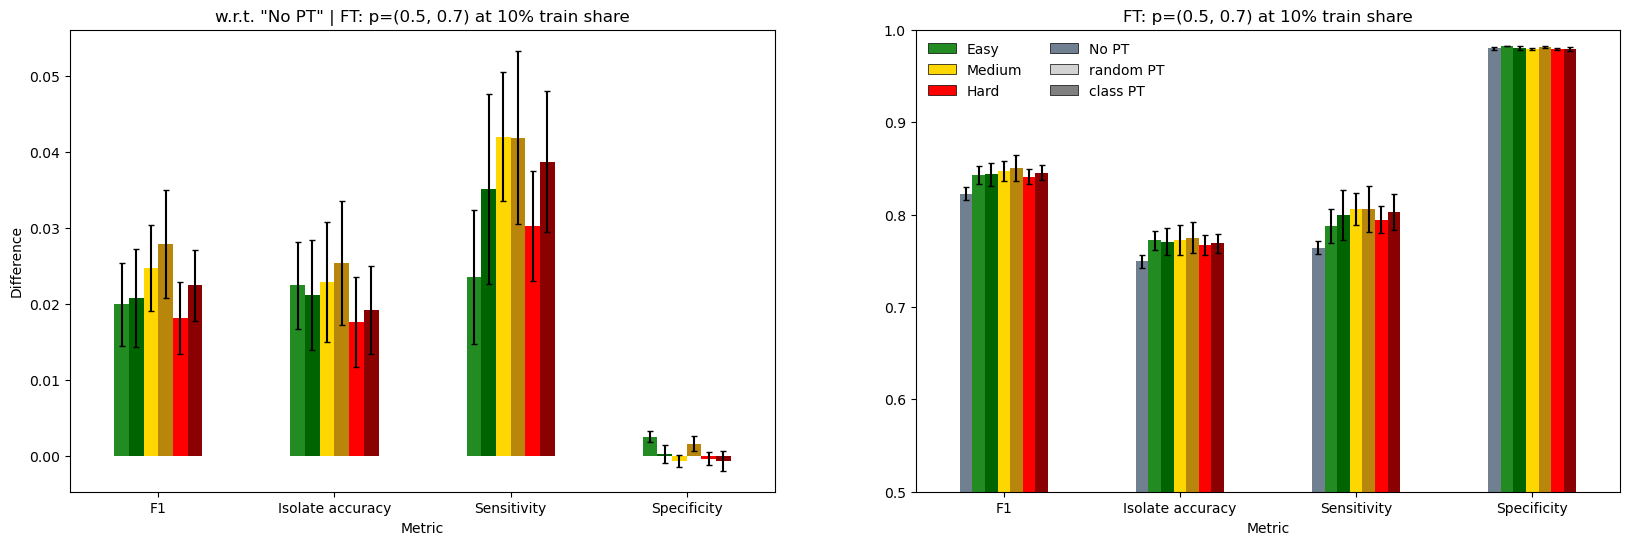

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_title('w.r.t. "No PT" | FT: p=(0.5, 0.7) at 10% train share')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax2.legend(
    handles=[easyPT, mediumPT, hardPT, noPT, pt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')
ax2.set_title('FT: p=(0.5, 0.7) at 10% train share')

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_0.5_0.7_diff_0.1.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()


FT: Class masking

In [95]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.75_class', '0.1')

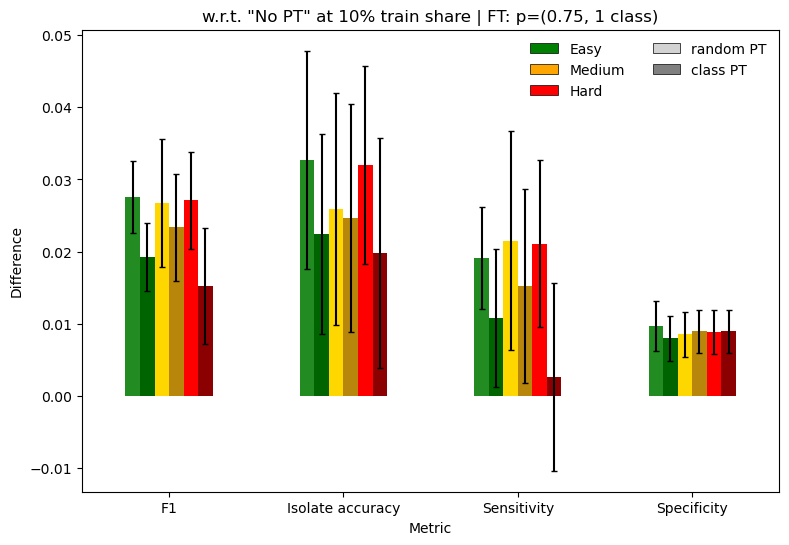

In [96]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('w.r.t. "No PT" at 10% train share | FT: p=(0.75, 1 class)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0, 
    # loc='lower right',
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_rel_diff_w_error_0.1.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

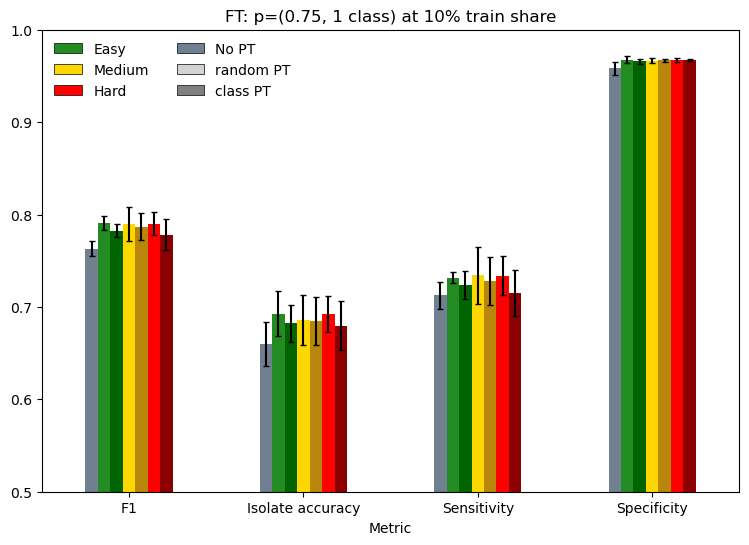

In [97]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.5, 1)
plt.xlabel('Metric')
plt.title('FT: p=(0.75, 1 class) at 10% train share')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_abs_diff_0.1.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

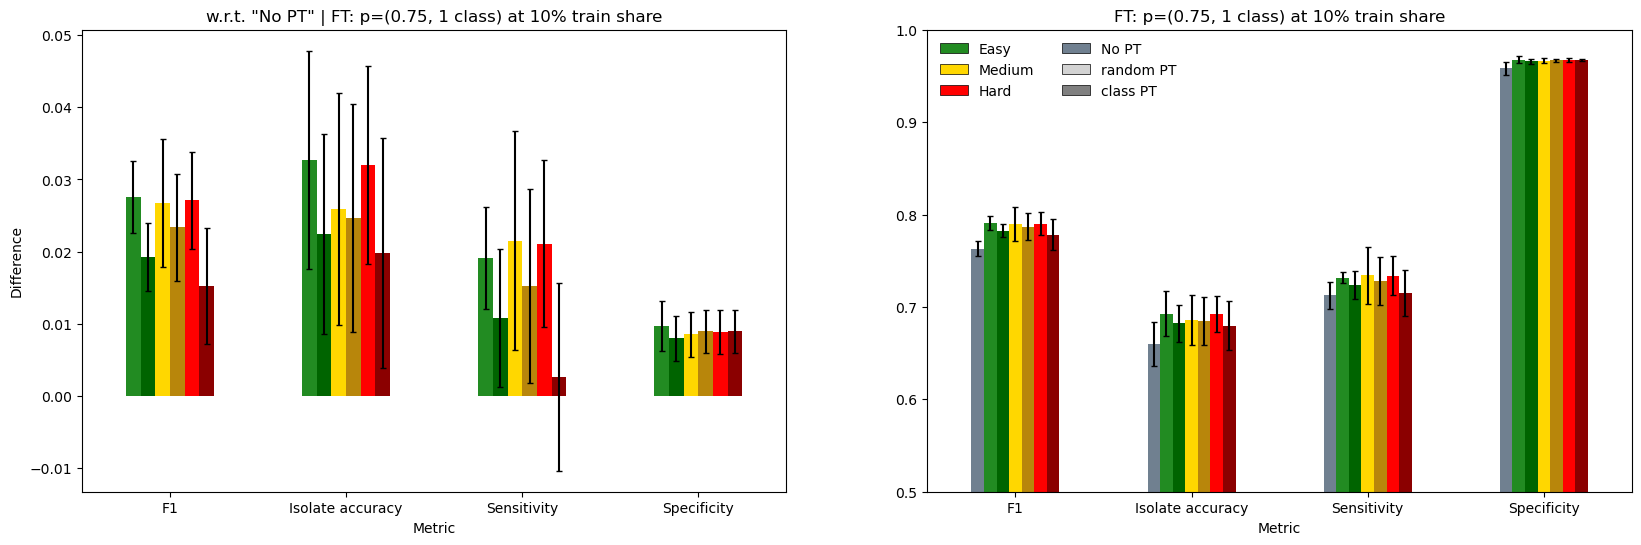

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_title('w.r.t. "No PT" | FT: p=(0.75, 1 class) at 10% train share')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax2.legend(
    handles=[easyPT, mediumPT, hardPT, noPT, pt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')
ax2.set_title('FT: p=(0.75, 1 class) at 10% train share')

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_diff_0.1.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()


### TS = 30%

FT: Random masking, p=(0.75,0.9)

In [99]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.75_0.9', '0.3')

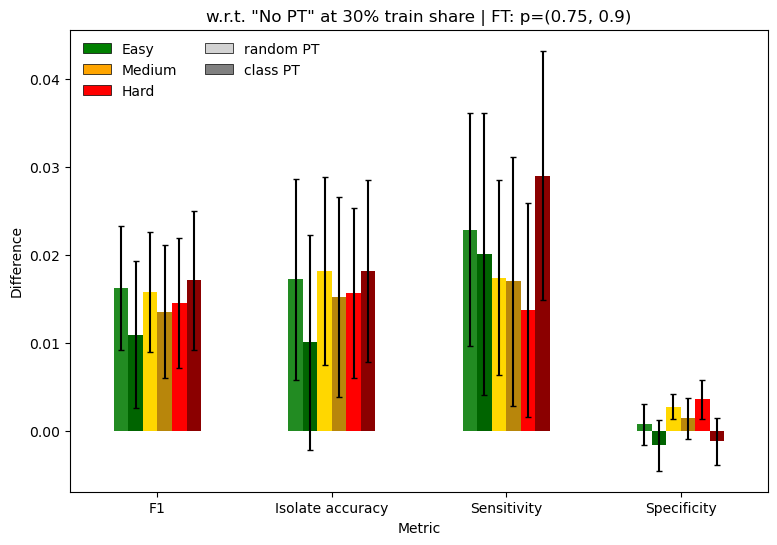

In [100]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('w.r.t. "No PT" at 30% train share | FT: p=(0.75, 0.9)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0, 
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_rel_diff_w_error_0.3.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

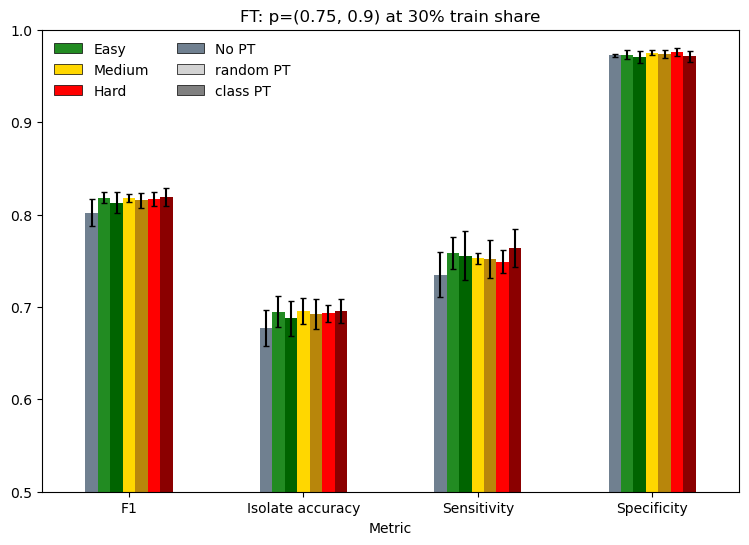

In [101]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.5, 1)
plt.xlabel('Metric')
plt.title('FT: p=(0.75, 0.9) at 30% train share')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_abs_diff_0.3.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

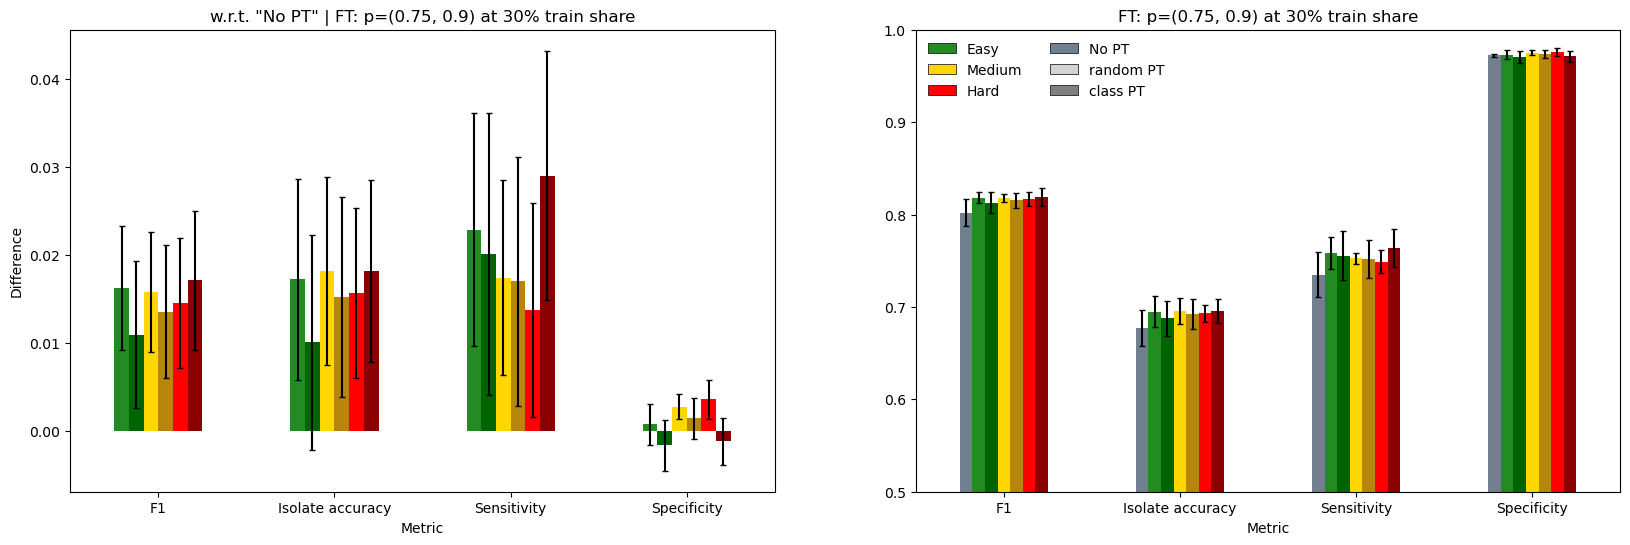

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_title('w.r.t. "No PT" | FT: p=(0.75, 0.9) at 30% train share')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax2.legend(
    handles=[easyPT, mediumPT, hardPT, noPT, pt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')
ax2.set_title('FT: p=(0.75, 0.9) at 30% train share')

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_diff_0.3.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()


FT: Random masking, p=(0.5,0.7)

In [103]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.5_0.7', '0.3')

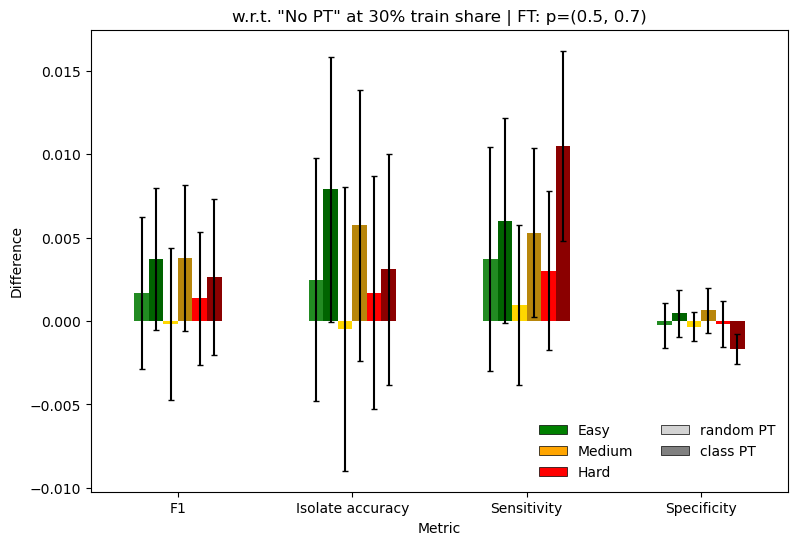

In [104]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('w.r.t. "No PT" at 30% train share | FT: p=(0.5, 0.7)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0, 
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_0.5_0.7_rel_diff_w_error_0.3.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

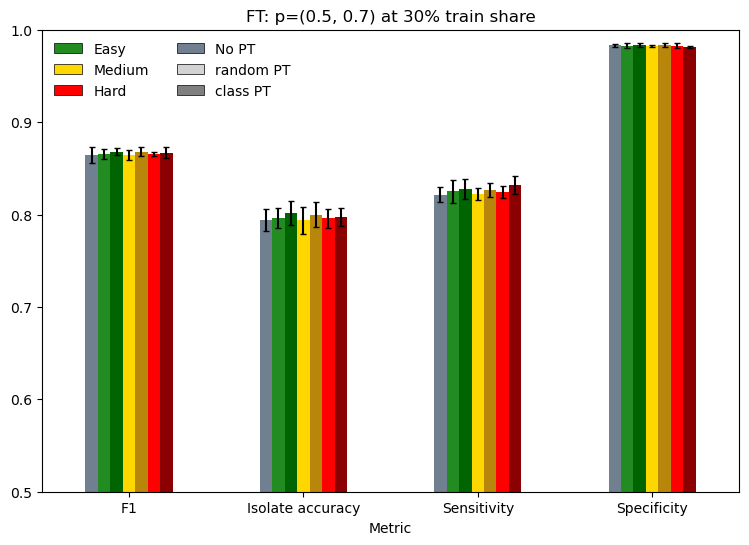

In [105]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.5, 1)
plt.xlabel('Metric')
plt.title('FT: p=(0.5, 0.7) at 30% train share')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_0.5_0.7_abs_diff_0.3.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

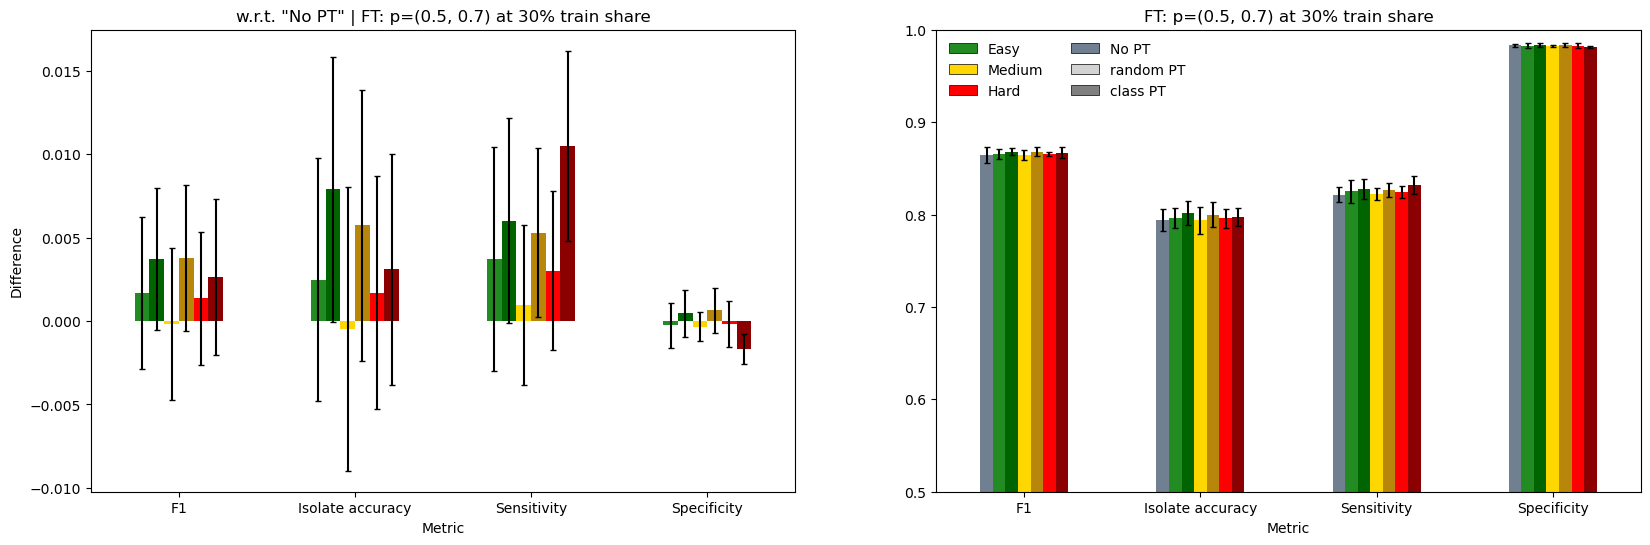

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_title('w.r.t. "No PT" | FT: p=(0.5, 0.7) at 30% train share')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax2.legend(
    handles=[easyPT, mediumPT, hardPT, noPT, pt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')
ax2.set_title('FT: p=(0.5, 0.7) at 30% train share')

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'randFT_0.5_0.7_diff_0.3.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()


FT: Class masking

In [107]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0.75_class', '0.3')

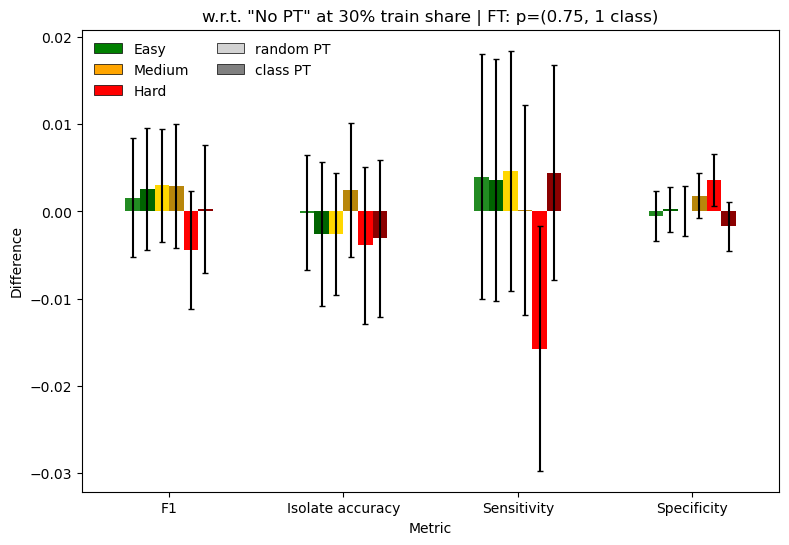

In [108]:
fig, ax = plt.subplots(figsize=(9, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), color=colors[1:], ax=ax, capsize=2, ecolor='k')
ax.set_title('w.r.t. "No PT" at 30% train share | FT: p=(0.75, 1 class)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0, 
    # loc='lower right',
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_rel_diff_w_error_0.3.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

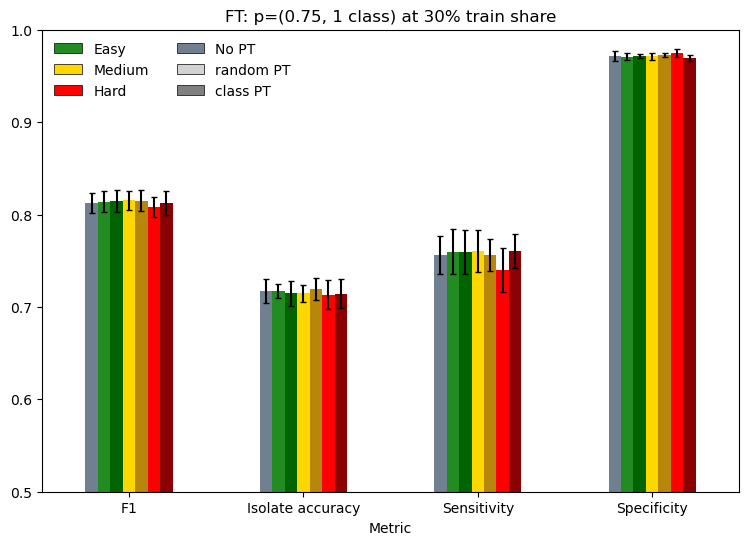

In [109]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.5, 1)
plt.xlabel('Metric')
plt.title('FT: p=(0.75, 1 class) at 30% train share')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_abs_diff_0.3.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

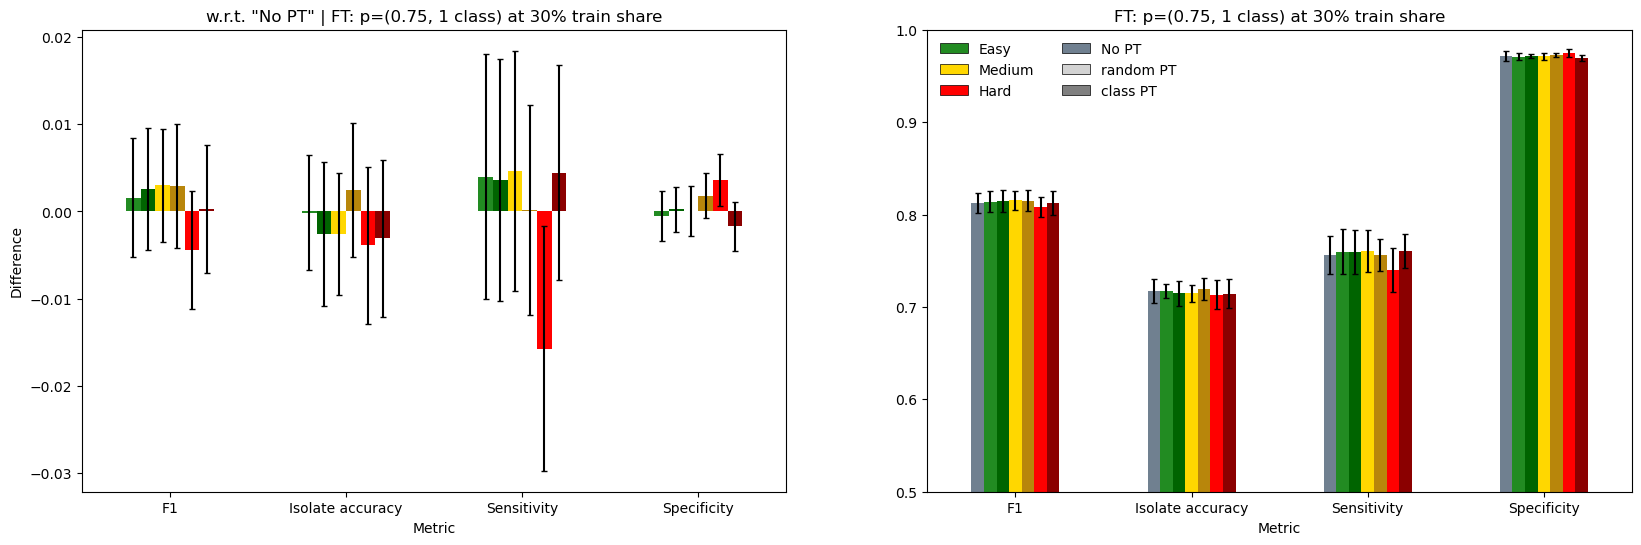

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_title('w.r.t. "No PT" | FT: p=(0.75, 1 class) at 30% train share')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax2.legend(
    handles=[easyPT, mediumPT, hardPT, noPT, pt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')
ax2.set_title('FT: p=(0.75, 1 class) at 30% train share')

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'classFT_diff_0.3.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()


# Look at including more antibiotics

## 17 antibiotics

In [111]:
results_random = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_17_noPT_0.75_0.9', 'CV_results.pkl'))
# results_random = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_17_noPT_0.75_0.7', 'CV_results.pkl'))
results_class = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_17_noPT_0.75_class', 'CV_results.pkl'))
results_1known = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_17_noPT_0.75_1known', 'CV_results.pkl'))

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\jespe\\Documents\\GitHub_local\\ARFusion\\results\\MM\\FT_17_noPT_0.75_0.9\\CV_results.pkl'

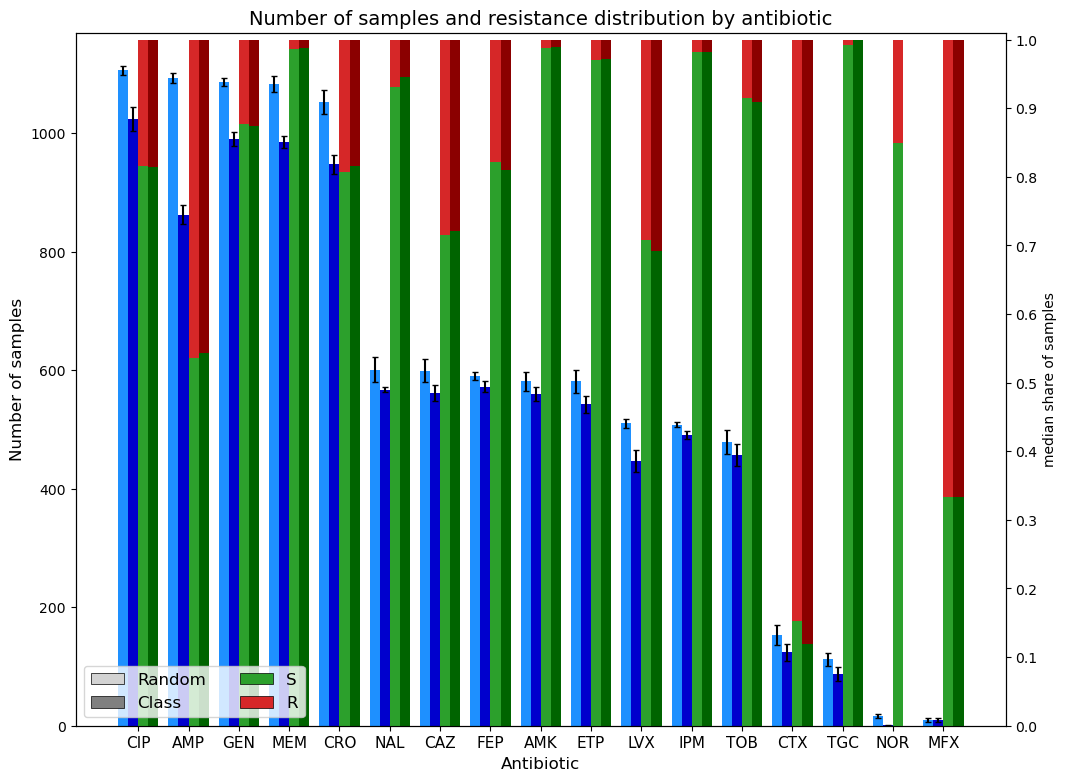

In [ ]:
df_ab_random = get_ab_stats_df(results_random, with_ab_as_index=True)
df_ab_class = get_ab_stats_df(results_class, with_ab_as_index=True)

fig, ax = plt.subplots(figsize=(12, 9))
bar_width = 0.2
df_ab_random = df_ab_random.sort_values(by='avg_num', ascending=False)
df_ab_class = df_ab_class.reindex_like(df_ab_random)
ind = np.arange(len(df_ab_random.index))
bar_num = ax.bar(
    ind-3/2*bar_width, df_ab_random['avg_num'], width=bar_width, color='dodgerblue',
    yerr=df_ab_random['std_num'], capsize=2, ecolor='k'
)
bar_num_class = ax.bar(
    ind-bar_width/2, df_ab_class['avg_num'], width=bar_width, color='mediumblue',
    yerr=df_ab_class['std_num'], capsize=2, ecolor='k'
)
ax2 = ax.twinx()
bar_R_share = ax2.bar(
    ind+bar_width/2, df_ab_random['R_share_median'], bottom=df_ab_random['S_share_median'], width=bar_width, color='tab:red'
)
bar_S_share = ax2.bar(
    ind+bar_width/2, df_ab_random['S_share_median'], width=bar_width, color='tab:green'
)
bar_R_share_class = ax2.bar(
    ind+3/2*bar_width, df_ab_class['R_share_median'], bottom=df_ab_class['S_share_median'], width=bar_width, color='darkred'
)
bar_S_share_class = ax2.bar(
    ind+3/2*bar_width, df_ab_class['S_share_median'], width=bar_width, color='darkgreen'
)
ax.set_xticks(ind, df_ab_random.index, fontsize=11)
ax.set_title('Number of samples and resistance distribution by antibiotic', fontsize=14)
ax.set_xlabel('Antibiotic', fontsize=12)
ax.set_ylabel('Number of samples', fontsize=12)
ax2.set_ylabel('median share of samples')
ax2.set_ylim(0, 1.01)
ax2.set_yticks(np.arange(0, 1.01, 0.1))

# custom legend
from matplotlib.patches import Rectangle

num_rand = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
num_class = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
S_share = Rectangle((0,0),1,1,fc='tab:green', edgecolor='k', linewidth=0.5)
R_share = Rectangle((0,0),1,1,fc='tab:red', edgecolor='k', linewidth=0.5)

ax2.legend(
    handles=[num_rand, num_class, S_share, R_share], 
    labels=['Random', 'Class', 'S', 'R'],
    loc='lower left',
    fontsize=12, 
    ncols=2
)
plt.show()